### Load Data: BTCUSDT PERP, Time interval: 15min

In [2]:
import warnings  
import os 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('BTCUSDT_15m_2023-01-01_to_2025-08-31.csv')
df

open_time      open      high       low     close    volume  \
0      2023-01-01 00:00:00   16537.5   16538.0   16517.4   16517.4  1519.880   
1      2023-01-01 00:15:00   16517.4   16540.9   16513.4   16539.4  1312.854   
2      2023-01-01 00:30:00   16539.3   16539.4   16504.0   16514.4  1806.819   
3      2023-01-01 00:45:00   16514.5   16533.1   16513.9   16527.0   741.846   
4      2023-01-01 01:00:00   16527.1   16539.0   16524.1   16537.3   935.879   
...                    ...       ...       ...       ...       ...       ...   
93499  2025-08-31 22:45:00  108796.7  108887.5  108700.0  108842.4   600.194   
93500  2025-08-31 23:00:00  108842.3  108866.7  108557.6  108635.1   985.709   
93501  2025-08-31 23:15:00  108635.1  108635.1  108300.0  108336.8  1998.590   
93502  2025-08-31 23:30:00  108336.7  108388.4  108021.0  108218.9  3245.866   
93503  2025-08-31 23:45:00  108218.9  108314.1  108116.6  108208.4  1365.040   

                    close_time  quote_asset_volume  number_of_trades  \
0      2023-01-01 00:14:59.999        2.511942e+07              9087   
1      2023-01-01 00:29:59.999        2.169977e+07              7474   
2      2023-01-01 00:44:59.999        2.984469e+07              9773   
3      2023-01-01 00:59:59.999        1.225921e+07              5195   
4      2023-01-01 01:14:59.999        1.547247e+07              5576   
...                        ...                 ...               ...   
93499  2025-08-31 22:59:59.999        6.529195e+07             15186   
93500  2025-08-31 23:14:59.999        1.070972e+08             23199   
93501  2025-08-31 23:29:59.999        2.167275e+08             37012   
93502  2025-08-31 23:44:59.999        3.511658e+08             52789   
93503  2025-08-31 23:59:59.999        1.477152e+08             27211   

       taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                          607.483                  1.003987e+07       0  
1                          765.737                  1.265735e+07       0  
2                          753.099                  1.243763e+07       0  
3                          415.472                  6.865808e+06       0  
4                          600.744                  9.931656e+06       0  
...                            ...                           ...     ...  
93499                      259.060                  2.818375e+07       0  
93500                      355.478                  3.862418e+07       0  
93501                      736.187                  7.983358e+07       0  
93502                     1798.065                  1.945648e+08       0  
93503                      734.671                  7.950233e+07       0  

[93504 rows x 12 columns]

### FFT Signal Transform:
#### - ${X[k] = \sum_{n=0}^{N-1} x[n] e^{-i 2\pi kn / N}, \quad k = 0, 1, \dots, N-1}$
#### - $X[k]$：第 k 個頻率分量（複數）。
#### - $|X[k]|$：該頻率的「能量大小」。
#### - $\arg(X[k])$：相位，決定該週期波動在時間軸上的「起點」。


In [4]:
# 取收盤價
x = df["close"].values
n = len(x)
x_detr = x - np.mean(x)  # 去掉均值避免 DC 成分過大

In [5]:
# FFT
X = np.fft.rfft(x_detr)
freqs = np.fft.rfftfreq(n, d=1)  # 樣本間隔=1 (15m 當單位)

In [20]:
# 功率譜
power = np.abs(X) ** 2

In [7]:
X

array([-5.24894858e-07+0.00000000e+00j,  1.86059632e+08+1.55481688e+09j,
        1.70192438e+08+7.35329098e+08j, ...,
       -8.70263050e+04-3.33519189e+04j, -1.95353081e+04-2.73233330e+04j,
       -4.69476000e+04+0.00000000e+00j])

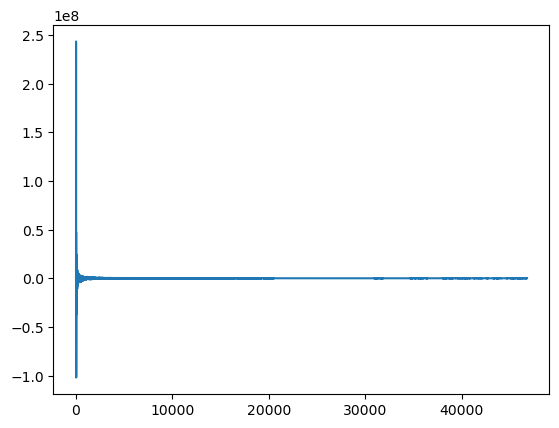

In [8]:
plt.plot(X)

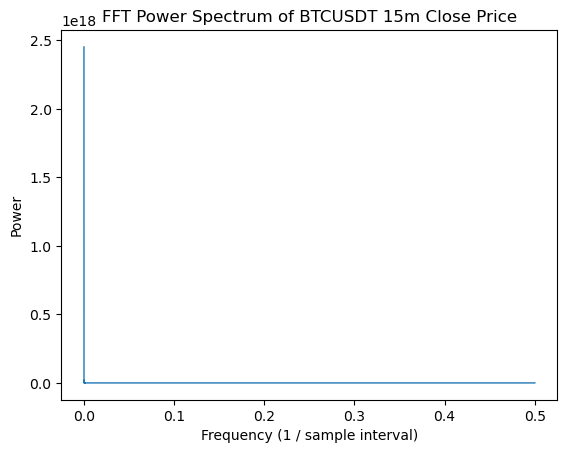

In [12]:
# 2. FFT Power Spectrum
plt.figure()
plt.plot(freqs[1:], power[1:], linewidth=1)  # 去掉0頻避免尺度過大
plt.title("FFT Power Spectrum of BTCUSDT 15m Close Price")
plt.xlabel("Frequency (1 / sample interval)")
plt.ylabel("Power")
plt.show()

In [21]:
from scipy import signal
x_detr = signal.detrend(df["close"].values)

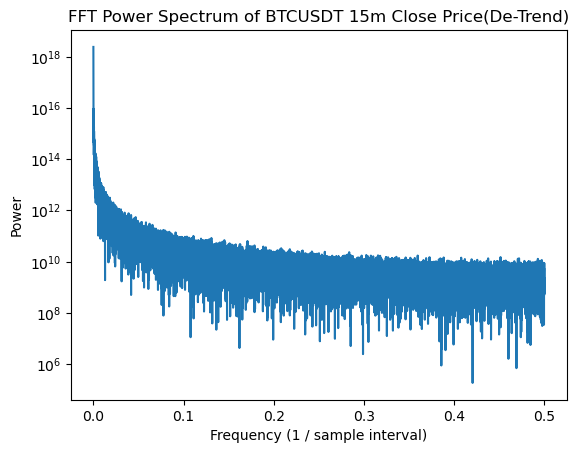

In [13]:
power = np.abs(X)**2
plt.ylabel("Power")
plt.xlabel("Frequency (1 / sample interval)")
plt.title("FFT Power Spectrum of BTCUSDT 15m Close Price(De-Trend)")

plt.semilogy(freqs[1:], power[1:])  # semilogy 可以讓小峰值放大看

### Log Return Signal

In [49]:
# Log Return
r = df["close"].pct_change().dropna().values
n = len(r)
R = np.fft.rfft(r)
# FFT
freqs = np.fft.rfftfreq(n, d=1)
power = np.abs(R) ** 2

In [50]:
r

array([ 1.33192875e-03, -1.51154214e-03,  7.62970498e-04, ...,
       -2.74588968e-03, -1.08827287e-03, -9.70255658e-05])

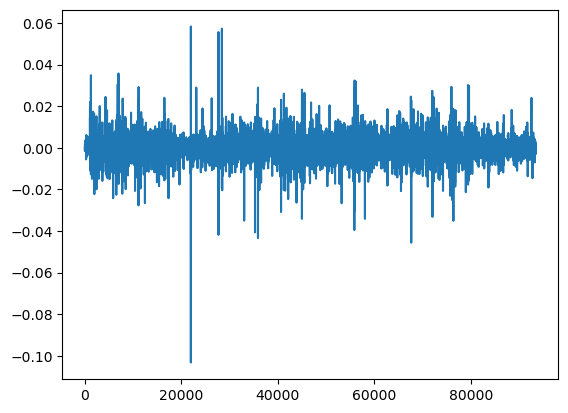

In [51]:
plt.plot(r)

### Return_Square & Volatility Signals

In [52]:
# 報酬率平方 & 絕對值
r2 = r**2
r_abs = np.abs(r)

# FFT function
def fft_power(x):
    X = np.fft.rfft(x - np.mean(x))   # 去均值避免0頻爆炸
    power = np.abs(X)**2
    freqs = np.fft.rfftfreq(len(x), d=1)  # d=1表示樣本間隔 = 1 (這裡代表15min)
    return freqs, power

In [53]:
# 計算功率譜
freq_r, power_r = fft_power(r)
freq_r2, power_r2 = fft_power(r2)
freq_abs, power_abs = fft_power(r_abs)

### r² 或 |r|：確認波動性有結構 

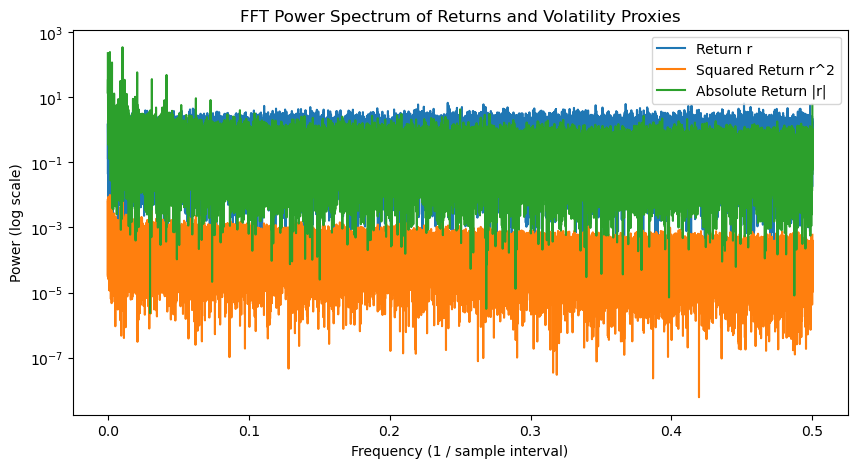

In [55]:
plt.figure(figsize=(10,5))
plt.semilogy(freq_r[1:], power_r[1:], label="Return r")
plt.semilogy(freq_r2[1:], power_r2[1:], label="Squared Return r^2")
plt.semilogy(freq_abs[1:], power_abs[1:], label="Absolute Return |r|")
plt.title("FFT Power Spectrum of Returns and Volatility Proxies")
plt.xlabel("Frequency (1 / sample interval)")
plt.ylabel("Power (log scale)")
plt.legend()
plt.show()

### 觀察不同時間維度下的信號變化

In [56]:
# 每根 K 線的時間間隔（這裡是 15 分鐘 = 0.25 小時）
dt_hours = 0.25
dt_days = dt_hours / 24  # 換算成天

In [57]:
def fft_power(x, dt):
    X = np.fft.rfft(x - np.mean(x))
    power = np.abs(X)**2
    freqs = np.fft.rfftfreq(len(x), d=dt)   # 依據時間間隔算頻率
    periods = 1 / freqs                     # 轉成週期
    return periods[1:], power[1:] 

In [58]:
# 計算 (小時為單位)
periods_h_r, power_r = fft_power(r, dt_hours)
periods_h_r2, power_r2 = fft_power(r2, dt_hours)
periods_h_abs, power_abs = fft_power(r_abs, dt_hours)

# 計算 (天為單位)
periods_d_r, power_r_d = fft_power(r, dt_days)
periods_d_r2, power_r2_d = fft_power(r2, dt_days)
periods_d_abs, power_abs_d = fft_power(r_abs, dt_days)


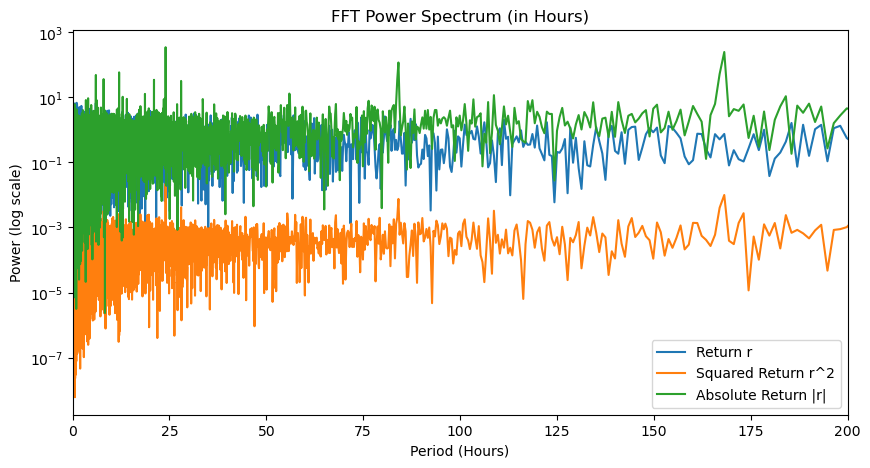

In [64]:
# -------- 繪圖：小時週期 --------
plt.figure(figsize=(10,5))
plt.semilogy(periods_h_r, power_r, label="Return r")
plt.semilogy(periods_h_r2, power_r2, label="Squared Return r^2")
plt.semilogy(periods_h_abs, power_abs, label="Absolute Return |r|")
plt.xlim(0, 200)  # 只看 0~200 小時內的週期
plt.xlabel("Period (Hours)")
plt.ylabel("Power (log scale)")
plt.title("FFT Power Spectrum (in Hours)")
plt.legend()
plt.show()

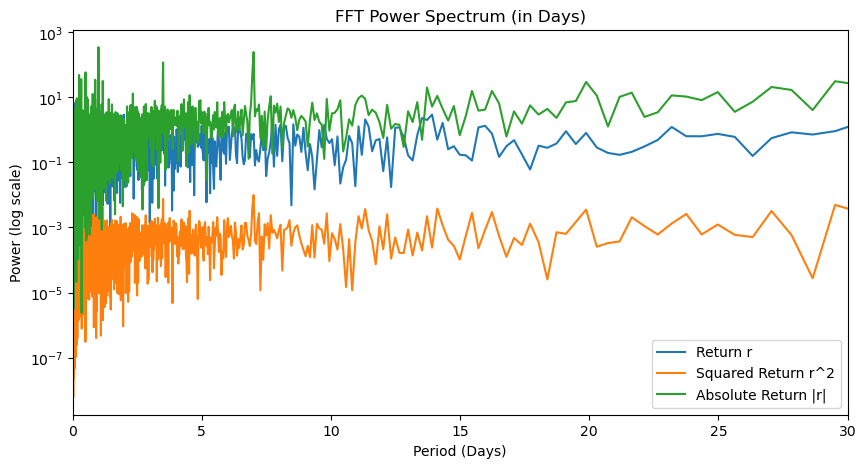

In [65]:
# --- 繪圖：天週期 --------
plt.figure(figsize=(10,5))
plt.semilogy(periods_d_r, power_r_d, label="Return r")
plt.semilogy(periods_d_r2, power_r2_d, label="Squared Return r^2")
plt.semilogy(periods_d_abs, power_abs_d, label="Absolute Return |r|")
plt.xlim(0, 30)  # 只看 0~60 天內的週期
plt.xlabel("Period (Days)")
plt.ylabel("Power (log scale)")
plt.title("FFT Power Spectrum (in Days)")
plt.legend()
plt.show()

### 上述結論：二階報酬率 (r²、|r|)：有結構、長記憶，波動性是可以分析與建模的。

In [67]:
df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore'],
      dtype='object')

In [68]:
# 用 close_time 當時間索引
df["close_time"] = pd.to_datetime(df["close_time"])
df = df.set_index("close_time")

In [69]:
df

open_time      open      high       low  \
close_time                                                                   
2023-01-01 00:14:59.999  2023-01-01 00:00:00   16537.5   16538.0   16517.4   
2023-01-01 00:29:59.999  2023-01-01 00:15:00   16517.4   16540.9   16513.4   
2023-01-01 00:44:59.999  2023-01-01 00:30:00   16539.3   16539.4   16504.0   
2023-01-01 00:59:59.999  2023-01-01 00:45:00   16514.5   16533.1   16513.9   
2023-01-01 01:14:59.999  2023-01-01 01:00:00   16527.1   16539.0   16524.1   
...                                      ...       ...       ...       ...   
2025-08-31 22:59:59.999  2025-08-31 22:45:00  108796.7  108887.5  108700.0   
2025-08-31 23:14:59.999  2025-08-31 23:00:00  108842.3  108866.7  108557.6   
2025-08-31 23:29:59.999  2025-08-31 23:15:00  108635.1  108635.1  108300.0   
2025-08-31 23:44:59.999  2025-08-31 23:30:00  108336.7  108388.4  108021.0   
2025-08-31 23:59:59.999  2025-08-31 23:45:00  108218.9  108314.1  108116.6   

                            close    volume  quote_asset_volume  \
close_time                                                        
2023-01-01 00:14:59.999   16517.4  1519.880        2.511942e+07   
2023-01-01 00:29:59.999   16539.4  1312.854        2.169977e+07   
2023-01-01 00:44:59.999   16514.4  1806.819        2.984469e+07   
2023-01-01 00:59:59.999   16527.0   741.846        1.225921e+07   
2023-01-01 01:14:59.999   16537.3   935.879        1.547247e+07   
...                           ...       ...                 ...   
2025-08-31 22:59:59.999  108842.4   600.194        6.529195e+07   
2025-08-31 23:14:59.999  108635.1   985.709        1.070972e+08   
2025-08-31 23:29:59.999  108336.8  1998.590        2.167275e+08   
2025-08-31 23:44:59.999  108218.9  3245.866        3.511658e+08   
2025-08-31 23:59:59.999  108208.4  1365.040        1.477152e+08   

                         number_of_trades  taker_buy_base_asset_volume  \
close_time                                                               
2023-01-01 00:14:59.999              9087                      607.483   
2023-01-01 00:29:59.999              7474                      765.737   
2023-01-01 00:44:59.999              9773                      753.099   
2023-01-01 00:59:59.999              5195                      415.472   
2023-01-01 01:14:59.999              5576                      600.744   
...                                   ...                          ...   
2025-08-31 22:59:59.999             15186                      259.060   
2025-08-31 23:14:59.999             23199                      355.478   
2025-08-31 23:29:59.999             37012                      736.187   
2025-08-31 23:44:59.999             52789                     1798.065   
2025-08-31 23:59:59.999             27211                      734.671   

                         taker_buy_quote_asset_volume  ignore  
close_time                                                     
2023-01-01 00:14:59.999                  1.003987e+07       0  
2023-01-01 00:29:59.999                  1.265735e+07       0  
2023-01-01 00:44:59.999                  1.243763e+07       0  
2023-01-01 00:59:59.999                  6.865808e+06       0  
2023-01-01 01:14:59.999                  9.931656e+06       0  
...                                               ...     ...  
2025-08-31 22:59:59.999                  2.818375e+07       0  
2025-08-31 23:14:59.999                  3.862418e+07       0  
2025-08-31 23:29:59.999                  7.983358e+07       0  
2025-08-31 23:44:59.999                  1.945648e+08       0  
2025-08-31 23:59:59.999                  7.950233e+07       0  

[93504 rows x 11 columns]

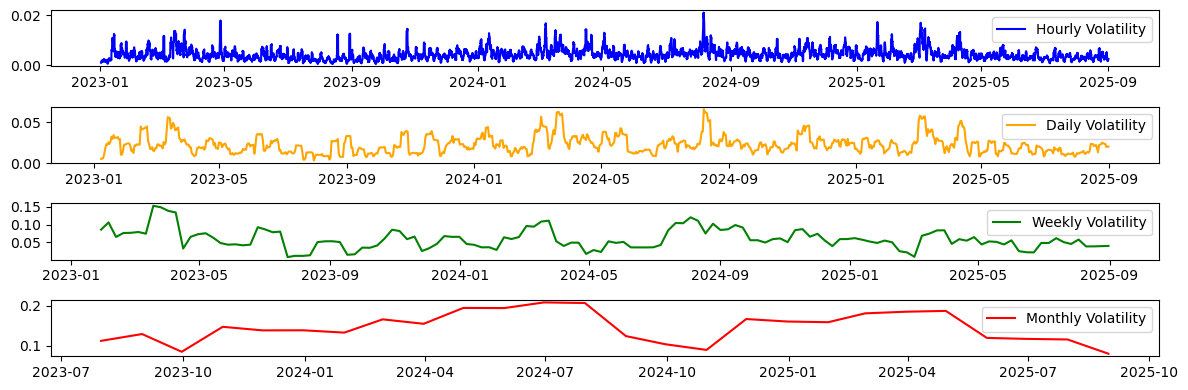

In [71]:
# =========================
# 1. 計算報酬率
# =========================
df["ret"] = df["close"].pct_change()

# =========================
# 2. 波動率估計方法
# - 這裡用移動標準差 (簡單實用)
# - 也可以替換成 Parkinson / Garman-Klass 等
# =========================
def realized_vol(series, window):
    return series.rolling(window).std()

# =========================
# 3. 不同時間維度的波動率
# =========================

# ---- 小時級 (日內) ----
df_1h = df.resample("1H").agg({"open":"first","high":"max","low":"min","close":"last"})
df_1h["ret"] = df_1h["close"].pct_change()
df_1h["vol"] = realized_vol(df_1h["ret"], window=24)  # 24h移動視窗

# ---- 日級 ----
df_1d = df.resample("1D").agg({"open":"first","high":"max","low":"min","close":"last"})
df_1d["ret"] = df_1d["close"].pct_change()
df_1d["vol"] = realized_vol(df_1d["ret"], window=7)   # 1週移動視窗

# ---- 週級 ----
df_1w = df.resample("1W").agg({"open":"first","high":"max","low":"min","close":"last"})
df_1w["ret"] = df_1w["close"].pct_change()
df_1w["vol"] = realized_vol(df_1w["ret"], window=4)   # 約1個月

# ---- 月級 ----
df_1m = df.resample("1M").agg({"open":"first","high":"max","low":"min","close":"last"})
df_1m["ret"] = df_1m["close"].pct_change()
df_1m["vol"] = realized_vol(df_1m["ret"], window=6)   # 半年視窗

# =========================
# 4. 繪圖比較
# =========================
plt.figure(figsize=(12,4))

plt.subplot(4,1,1)
plt.plot(df_1h.index, df_1h["vol"], label="Hourly Volatility", color="blue")
plt.legend()

plt.subplot(4,1,2)
plt.plot(df_1d.index, df_1d["vol"], label="Daily Volatility", color="orange")
plt.legend()

plt.subplot(4,1,3)
plt.plot(df_1w.index, df_1w["vol"], label="Weekly Volatility", color="green")
plt.legend()

plt.subplot(4,1,4)
plt.plot(df_1m.index, df_1m["vol"], label="Monthly Volatility", color="red")
plt.legend()

plt.tight_layout()
plt.show()

### FFT Transform the Volatility data in different timeframe

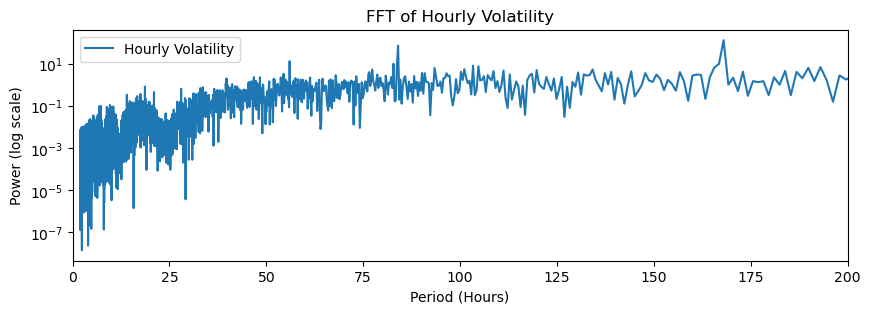

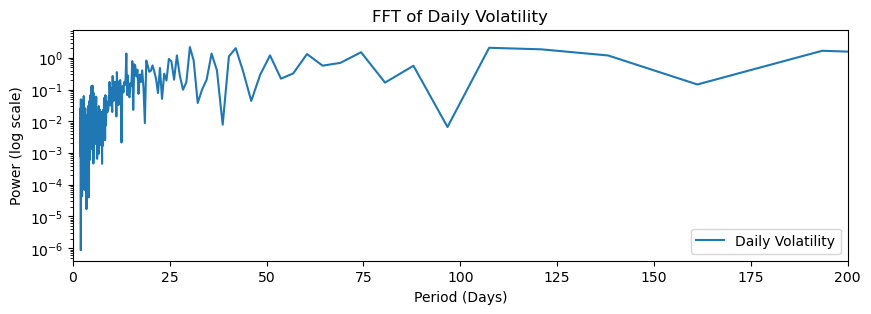

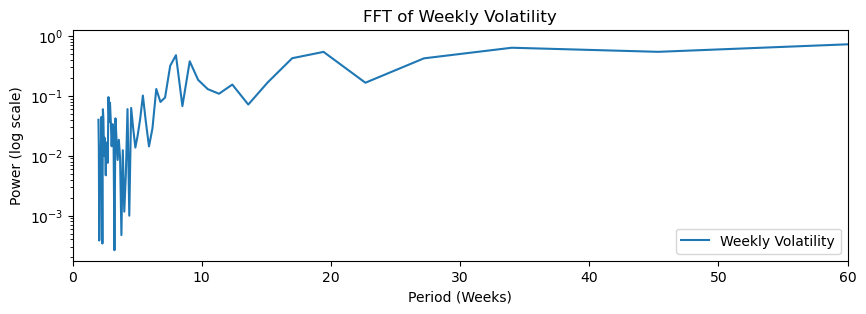

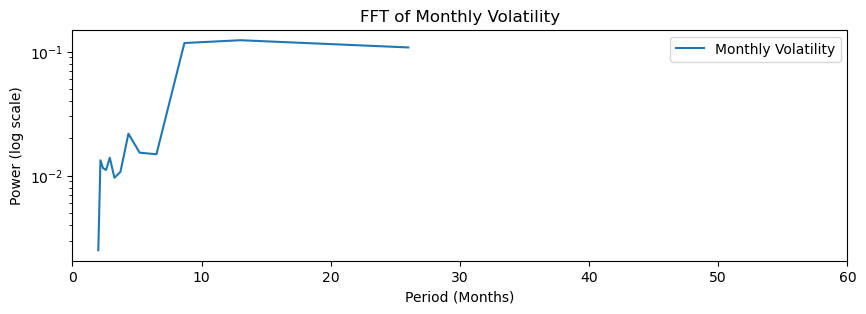

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# FFT helper function
def fft_power(series, dt, label):
    series = series.dropna().values
    n = len(series)
    X = np.fft.rfft(series - np.mean(series))   # 去均值避免0頻爆炸
    power = np.abs(X)**2
    freqs = np.fft.rfftfreq(n, d=dt)            # 頻率
    periods = 1 / freqs                         # 轉成週期
    return periods[1:], power[1:], label

# 計算 (不同時間維度的波動率序列)
periods_h, power_h, label_h = fft_power(df_1h["vol"], dt=1, label="Hourly Volatility")
periods_d, power_d, label_d = fft_power(df_1d["vol"], dt=1, label="Daily Volatility")
periods_w, power_w, label_w = fft_power(df_1w["vol"], dt=1, label="Weekly Volatility")
periods_m, power_m, label_m = fft_power(df_1m["vol"], dt=1, label="Monthly Volatility")

# -------- 繪圖 (小時級) --------
plt.figure(figsize=(10,3))
plt.semilogy(periods_h, power_h, label=label_h)
plt.xlim(0, 200)  # 只看 200 小時內 (~8天)
plt.xlabel("Period (Hours)")
plt.ylabel("Power (log scale)")
plt.title("FFT of Hourly Volatility")
plt.legend()
plt.show()

# -------- 繪圖 (日級) --------
plt.figure(figsize=(10,3))
plt.semilogy(periods_d, power_d, label=label_d)
plt.xlim(0, 200)   # 只看 60 天內 (~2個月)
plt.xlabel("Period (Days)")
plt.ylabel("Power (log scale)")
plt.title("FFT of Daily Volatility")
plt.legend()
plt.show()

# -------- 繪圖 (週級) --------
plt.figure(figsize=(10,3))
plt.semilogy(periods_w, power_w, label=label_w)
plt.xlim(0, 60)   # 只看 60 週 (~1年多)
plt.xlabel("Period (Weeks)")
plt.ylabel("Power (log scale)")
plt.title("FFT of Weekly Volatility")
plt.legend()
plt.show()

# -------- 繪圖 (月級) --------
plt.figure(figsize=(10,3))
plt.semilogy(periods_m, power_m, label=label_m)
plt.xlim(0, 60)   # 只看 60 月 (~5年)
plt.xlabel("Period (Months)")
plt.ylabel("Power (log scale)")
plt.title("FFT of Monthly Volatility")
plt.legend()
plt.show()

### ACF Plot 檢測週期性

<Figure size 1000x200 with 0 Axes>

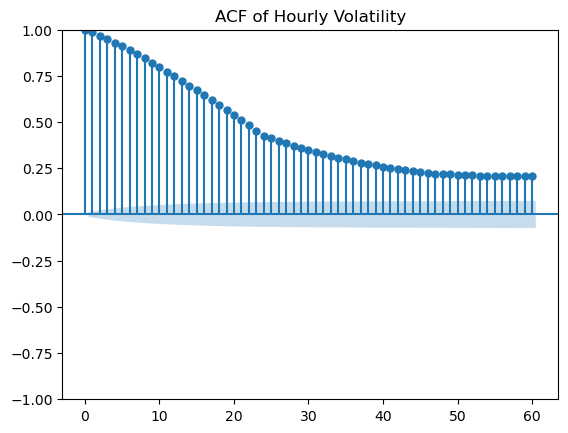

<Figure size 1000x200 with 0 Axes>

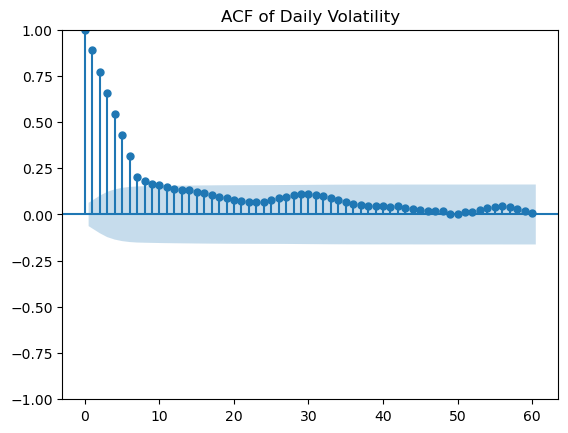

<Figure size 1000x300 with 0 Axes>

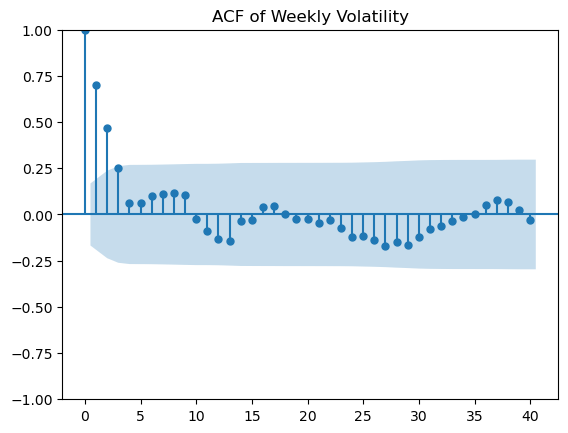

In [80]:
from statsmodels.graphics.tsaplots import plot_acf

# ACF for hourly volatility
plt.figure(figsize=(10,2))
plot_acf(df_1h["vol"].dropna(), lags = 60)
plt.title("ACF of Hourly Volatility")
plt.show()

# ACF for daily volatility
plt.figure(figsize=(10,2))
plot_acf(df_1d["vol"].dropna(), lags=60)
plt.title("ACF of Daily Volatility")
plt.show()

# ACF for weekly volatility
plt.figure(figsize=(10,3))
plot_acf(df_1w["vol"].dropna(), lags=40)
plt.title("ACF of Weekly Volatility")
plt.show()

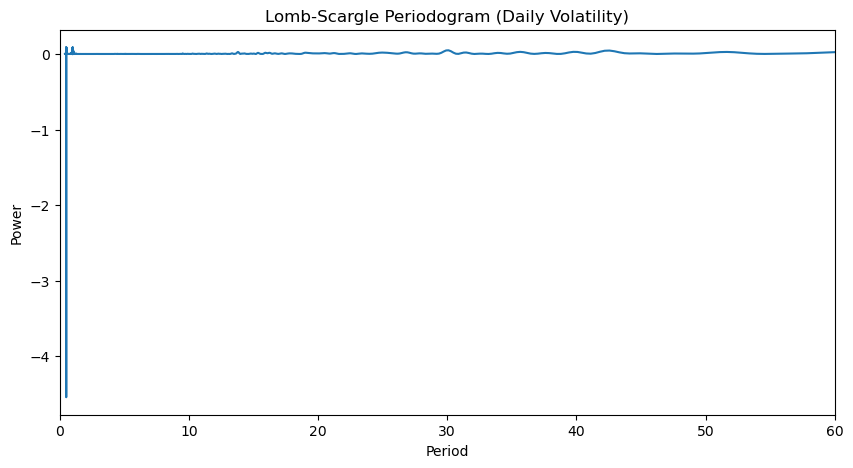

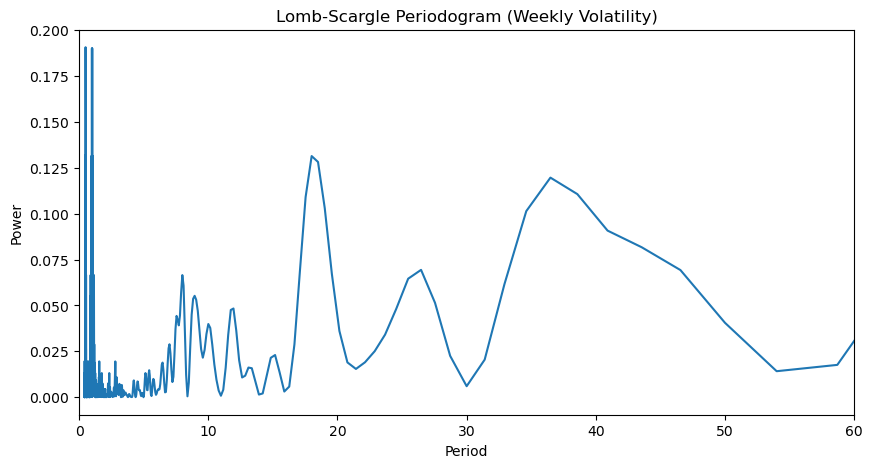

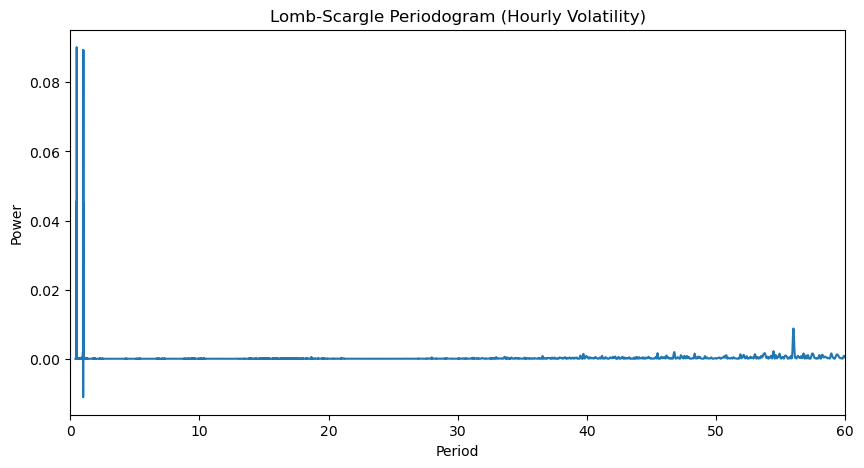

In [82]:
from astropy.timeseries import LombScargle

def lomb_scargle_test(series, dt, label, max_period):
    y = series.dropna().values
    x = np.arange(len(y)) * dt   # 時間軸
    
    freq, power = LombScargle(x, y).autopower()
    period = 1 / freq
    
    plt.figure(figsize=(10,5))
    plt.plot(period, power)
    plt.xlim(0, max_period)
    plt.xlabel("Period")
    plt.ylabel("Power")
    plt.title(f"Lomb-Scargle Periodogram ({label})")
    plt.show()

# Daily (檢查 60 天以內的週期性)
lomb_scargle_test(df_1d["vol"], dt=1, label="Daily Volatility", max_period=60)

# Weekly (檢查 60 週以內的週期性)
lomb_scargle_test(df_1w["vol"], dt=1, label="Weekly Volatility", max_period=60)

# Hourly
lomb_scargle_test(df_1h["vol"], dt=1, label ="Hourly Volatility", max_period=60)

### FFT Volatility Signals Heatmap

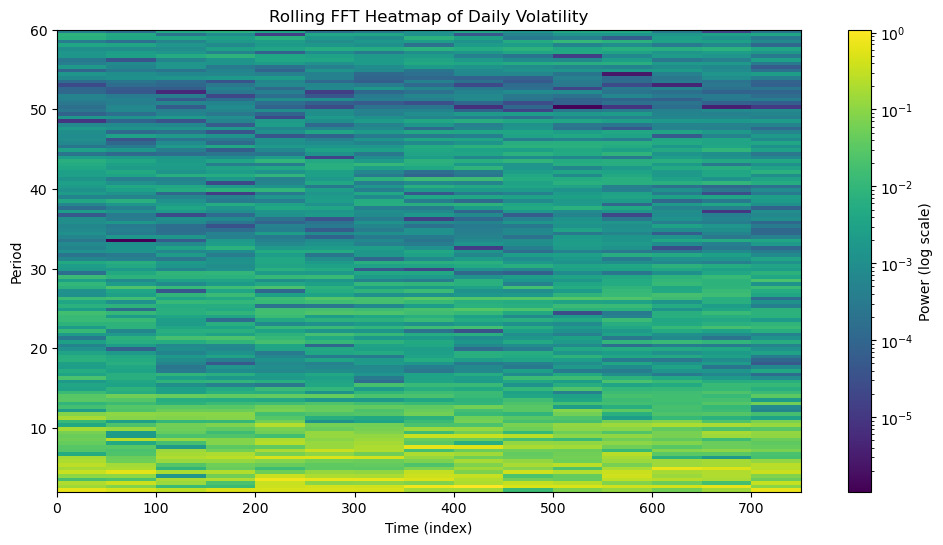

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def rolling_fft_heatmap(series, window=256, step=50, dt=1, max_period=60, label="Daily Volatility"):
    series = series.dropna().values
    n = len(series)

    spectra = []
    times = []

    for start in range(0, n - window, step):
        seg = series[start:start+window]
        seg = seg - np.mean(seg)
        X = np.fft.rfft(seg)
        power = np.abs(X)**2
        freqs = np.fft.rfftfreq(window, d=dt)
        periods = 1 / freqs
        spectra.append(power[1:])  # 去掉0頻
        times.append(start)

    spectra = np.array(spectra).T
    periods = periods[1:]

    # Heatmap
    plt.figure(figsize=(12,6))
    plt.imshow(
        spectra,
        aspect="auto",
        origin="lower",
        extent=[0, len(times)*step, periods.min(), max_period],
        cmap="viridis",
        norm=LogNorm()
    )
    plt.colorbar(label="Power (log scale)")
    plt.title(f"Rolling FFT Heatmap of {label}")
    plt.xlabel("Time (index)")
    plt.ylabel("Period")
    plt.show()

# 使用範例
rolling_fft_heatmap(df_1d["vol"], window=256, step=50, dt=1, max_period=60, label="Daily Volatility")

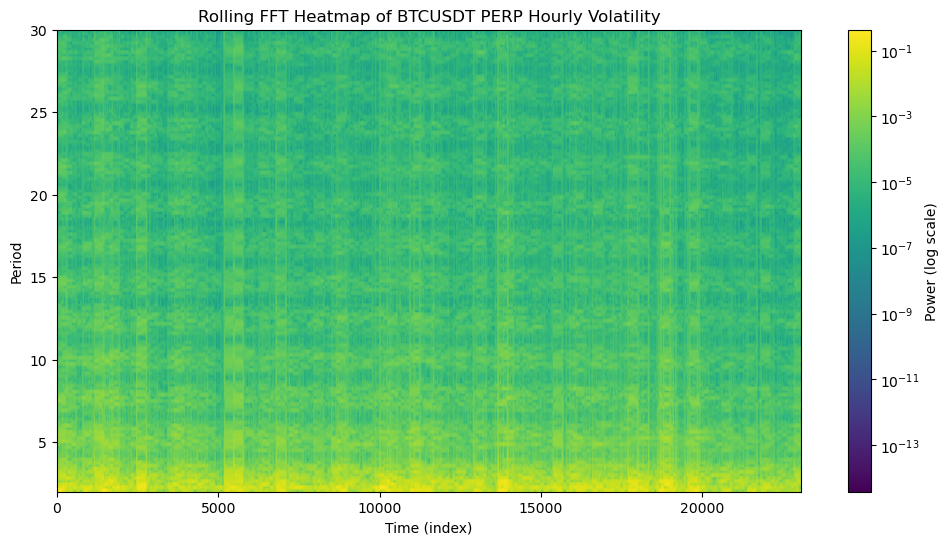

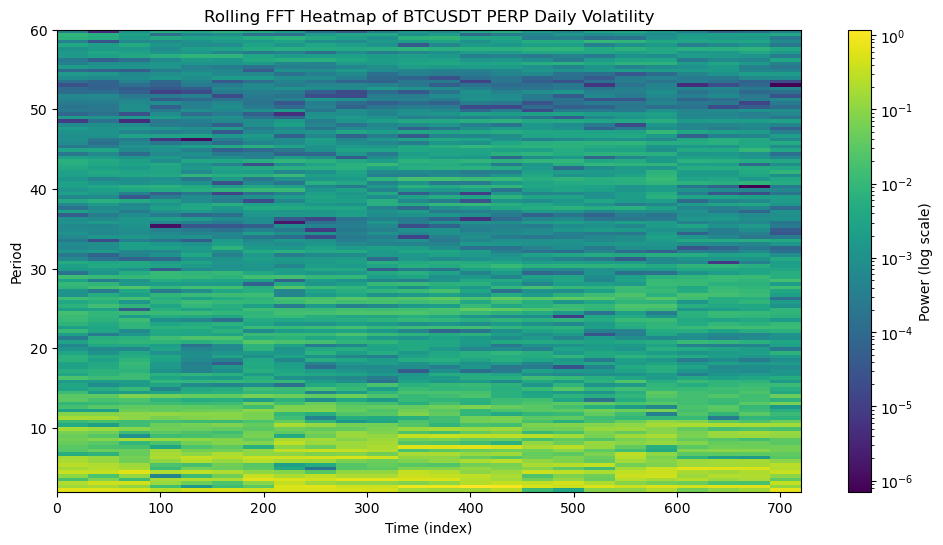

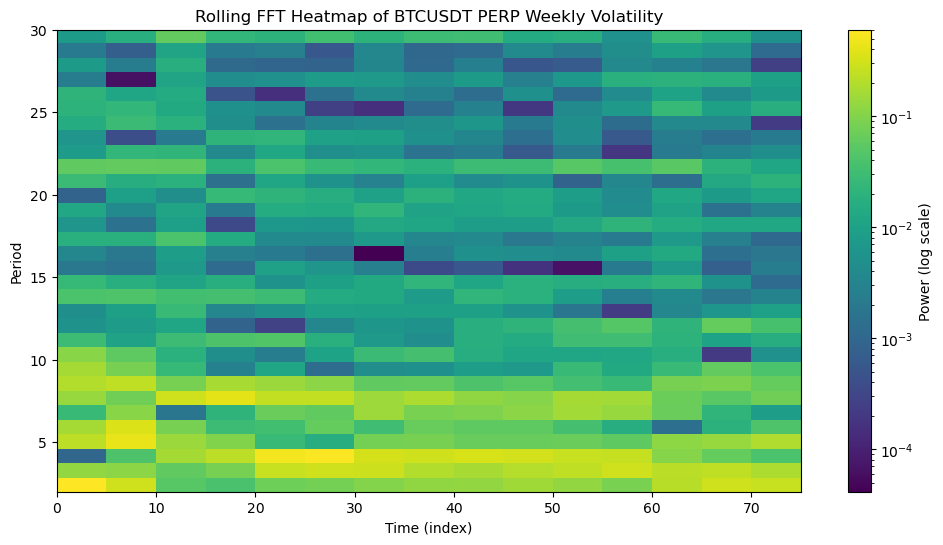

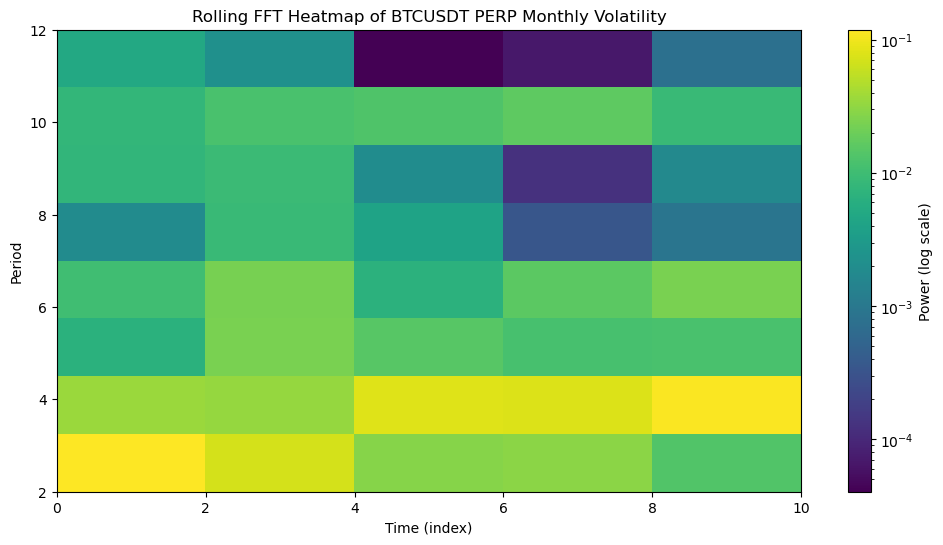

In [95]:
def rolling_fft_heatmap(series, window=256, step=50, dt=1, max_period=60, label="Volatility"):
    series = series.dropna().values
    n = len(series)

    if n < window:   # 防呆處理
        print(f"Series too short for window={window}, length={n}")
        return
    
    spectra = []
    times = []

    for start in range(0, n - window, step):
        seg = series[start:start+window]
        seg = seg - np.mean(seg)
        X = np.fft.rfft(seg)
        power = np.abs(X)**2
        freqs = np.fft.rfftfreq(window, d=dt)
        periods = 1 / freqs
        spectra.append(power[1:])  # 去掉0頻
        times.append(start)

    spectra = np.array(spectra).T
    periods = periods[1:]

    plt.figure(figsize=(12,6))
    plt.imshow(
        spectra,
        aspect="auto",
        origin="lower",
        extent=[0, len(times)*step, periods.min(), max_period],
        cmap="viridis",
        norm=LogNorm()
    )
    plt.colorbar(label="Power (log scale)")
    plt.title(f"Rolling FFT Heatmap of BTCUSDT PERP {label}")
    plt.xlabel("Time (index)")
    plt.ylabel("Period")
    plt.show()


# ===== 分別跑不同時間維度 =====
# 小時波動
rolling_fft_heatmap(df_1h["vol"], window=300, step=10, dt=1, max_period=30, label="Hourly Volatility")

# 日波動
rolling_fft_heatmap(df_1d["vol"], window=256, step=30, dt=1, max_period=60, label="Daily Volatility")

# 週波動
rolling_fft_heatmap(df_1w["vol"], window=64, step=5, dt=1, max_period=30, label="Weekly Volatility")

# 月波動
rolling_fft_heatmap(df_1m["vol"], window=16, step=2, dt=1, max_period=12, label="Monthly Volatility")

In [99]:
from matplotlib.colors import LogNorm

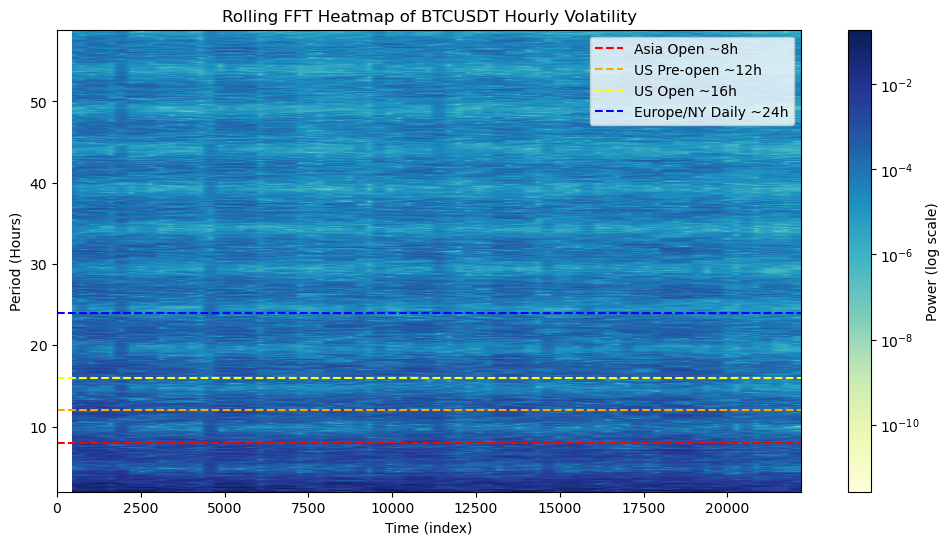

In [121]:
from matplotlib.colors import LogNorm

def rolling_fft_heatmap_with_sessions(series, window=300, step=15, dt=1, max_period=200, label="Hourly Volatility"):
    n = len(series)
    spectra = []
    times = []
    
    for start in range(0, n - window, step):
        segment = series[start:start+window]
        X = np.fft.rfft(segment - np.mean(segment))
        power = np.abs(X) ** 2
        freqs = np.fft.rfftfreq(window, d=dt)
        periods = 1 / freqs
        valid = periods <= max_period
        spectra.append(power[valid])
        times.append(start)
    
    spectra = np.array(spectra).T
    periods = periods[valid]

    plt.figure(figsize=(12,6))
    plt.imshow(
        spectra, aspect='auto', origin='lower',
        extent=[times[0], times[-1], periods.min(), periods.max()],
        cmap='YlGnBu', norm=LogNorm()
    )
    plt.colorbar(label="Power (log scale)")
    plt.xlabel("Time (index)")
    plt.ylabel("Period (Hours)")
    plt.title(f"Rolling FFT Heatmap of {label}")
    
    # 標記開盤週期
    plt.axhline(y=8, color='red', linestyle='--', label='Asia Open ~8h')
    plt.axhline(y=12, color='orange', linestyle='--', label='US Pre-open ~12h')
    plt.axhline(y=16, color='yellow', linestyle='--', label='US Open ~16h')
    plt.axhline(y=24, color='blue', linestyle='--', label='Europe/NY Daily ~24h')

    plt.legend()
    plt.show()

# 使用範例 (假設 df_1h["vol"] 是小時級波動率)
rolling_fft_heatmap_with_sessions(df_1h["vol"], window=1000, step=300, dt=1, max_period=60, label="BTCUSDT Hourly Volatility")

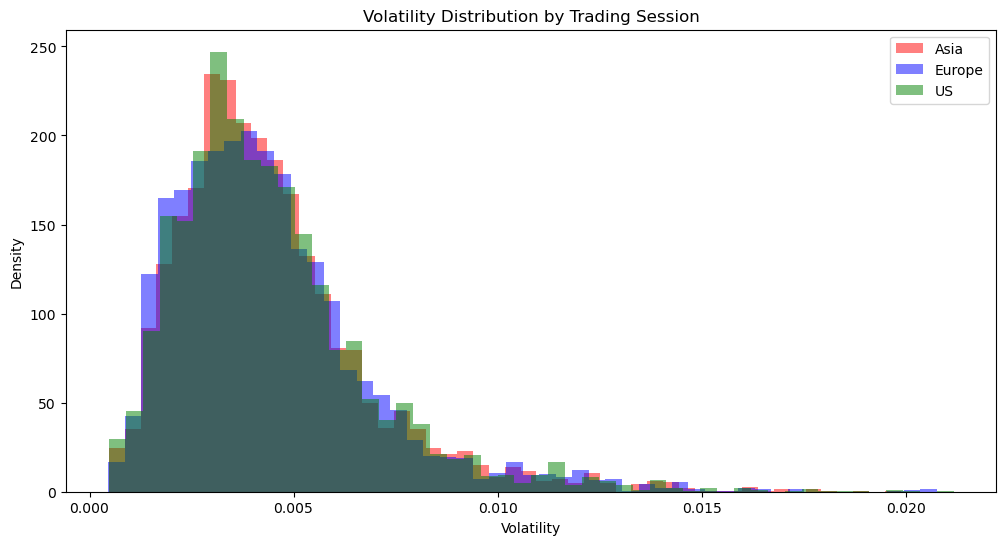

<Figure size 800x600 with 0 Axes>

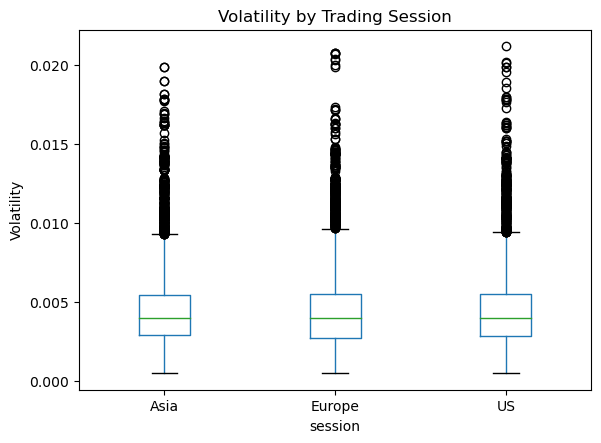

平均波動率：
session
Asia      0.004450
Europe    0.004421
US        0.004440
Name: vol, dtype: float64


In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設 df_1h 有 datetime index & "vol" 欄位
df_1h = df_1h.copy()
df_1h["hour"] = df_1h.index.hour

# 定義交易時段
def get_session(hour):
    if 8 <= hour < 16:
        return "Asia"
    elif 16 <= hour < 24:
        return "Europe"
    else:
        return "US"

df_1h["session"] = df_1h["hour"].apply(get_session)

# 畫直方圖
plt.figure(figsize=(12,6))
for session, color in zip(["Asia", "Europe", "US"], ["red", "blue", "green"]):
    subset = df_1h[df_1h["session"] == session]["vol"]
    plt.hist(subset, bins=50, alpha=0.5, label=session, color=color, density=True)

plt.title("Volatility Distribution by Trading Session")
plt.xlabel("Volatility")
plt.ylabel("Density")
plt.legend()
plt.show()

# 畫箱型圖
plt.figure(figsize=(8,6))
df_1h.boxplot(column="vol", by="session", grid=False)
plt.title("Volatility by Trading Session")
plt.suptitle("")
plt.ylabel("Volatility")
plt.show()

# 計算平均值
session_means = df_1h.groupby("session")["vol"].mean()
print("平均波動率：")
print(session_means)

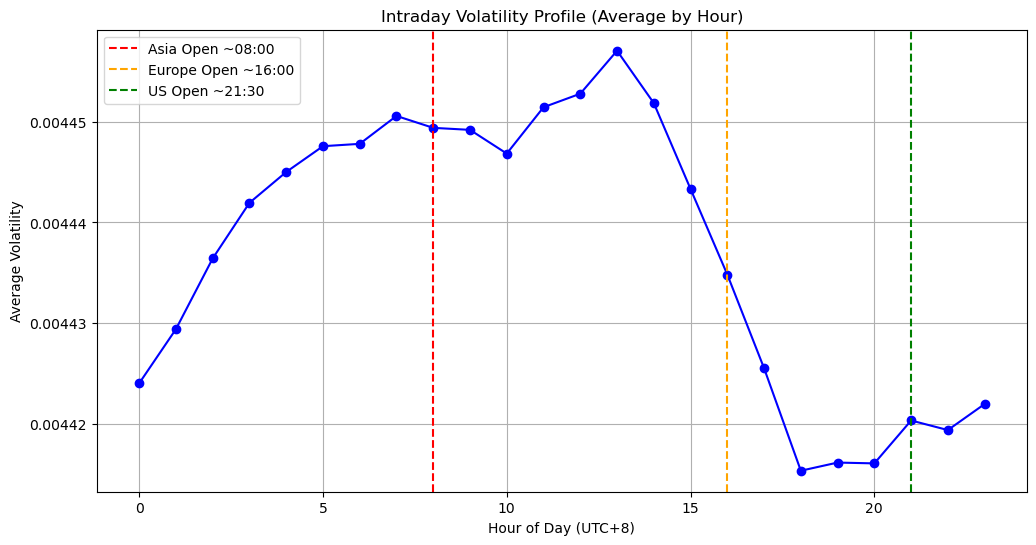

In [123]:
# 假設 df_1h 有 datetime index + "vol"
df_intraday = df_1h.copy()
df_intraday["hour"] = df_intraday.index.hour

# 計算每個小時的平均波動率
hourly_profile = df_intraday.groupby("hour")["vol"].mean()

# 畫圖
plt.figure(figsize=(12,6))
plt.plot(hourly_profile.index, hourly_profile.values, marker="o", color="blue")
plt.title("Intraday Volatility Profile (Average by Hour)")
plt.xlabel("Hour of Day (UTC+8)")
plt.ylabel("Average Volatility")
plt.grid(True)

# 標記重要時段
plt.axvline(x=8, color="red", linestyle="--", label="Asia Open ~08:00")
plt.axvline(x=16, color="orange", linestyle="--", label="Europe Open ~16:00")
plt.axvline(x=21, color="green", linestyle="--", label="US Open ~21:30")
plt.legend()
plt.show()

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假設 df_1h["vol"] 是小時波動率
vol = df_1h["vol"].values
n = len(vol)

# 做 FFT
fft_vals = np.fft.rfft(vol - np.mean(vol))
power = np.abs(fft_vals)**2
freqs = np.fft.rfftfreq(n, d=1)   # 取樣間隔 d=1 小時
periods = 1 / freqs
periods[0] = np.inf  # 避免除以 0

# 建表
df_fft = pd.DataFrame({
    "period": periods,
    "power": power
})
df_fft = df_fft.replace([np.inf], np.nan).dropna()

# 加上時間（對應原始 index）
df_fft["time"] = np.linspace(0, n, len(df_fft))

# 加上交易時段
df_fft["hour"] = df_1h.index.hour[:len(df_fft)]

def get_session(hour):
    if 8 <= hour < 16:
        return "Asia"
    elif 16 <= hour < 21:
        return "Europe"
    else:
        return "US"

df_fft["session"] = df_fft["hour"].apply(get_session)

# 放寬篩選範圍
target = df_fft[(df_fft["period"]>=6) & (df_fft["period"]<=10)]

if target.empty:
    print("⚠️ 沒有找到符合範圍的週期，建議放寬 period 範圍。")
else:
    plt.figure(figsize=(10,6))
    sns.histplot(data=target, x="power", hue="session",
                 element="step", stat="density", common_norm=False)
    plt.title("Distribution of ~8h Cycle Signal Strength by Session")
    plt.xlabel("FFT Power (Signal Strength)")
    plt.xscale("log")
    plt.show()

⚠️ 沒有找到符合範圍的週期，建議放寬 period 範圍。


In [132]:
print(df_fft.head())
print(df_fft.columns)
print(df_fft.describe())

Empty DataFrame
Columns: [period, power, time, hour, session]
Index: []
Index(['period', 'power', 'time', 'hour', 'session'], dtype='object')
       period  power  time  hour  session
count     0.0    0.0   0.0   0.0      0.0
mean      NaN    NaN   NaN   NaN      NaN
std       NaN    NaN   NaN   NaN      NaN
min       NaN    NaN   NaN   NaN      NaN
25%       NaN    NaN   NaN   NaN      NaN
50%       NaN    NaN   NaN   NaN      NaN
75%       NaN    NaN   NaN   NaN      NaN
max       NaN    NaN   NaN   NaN      NaN


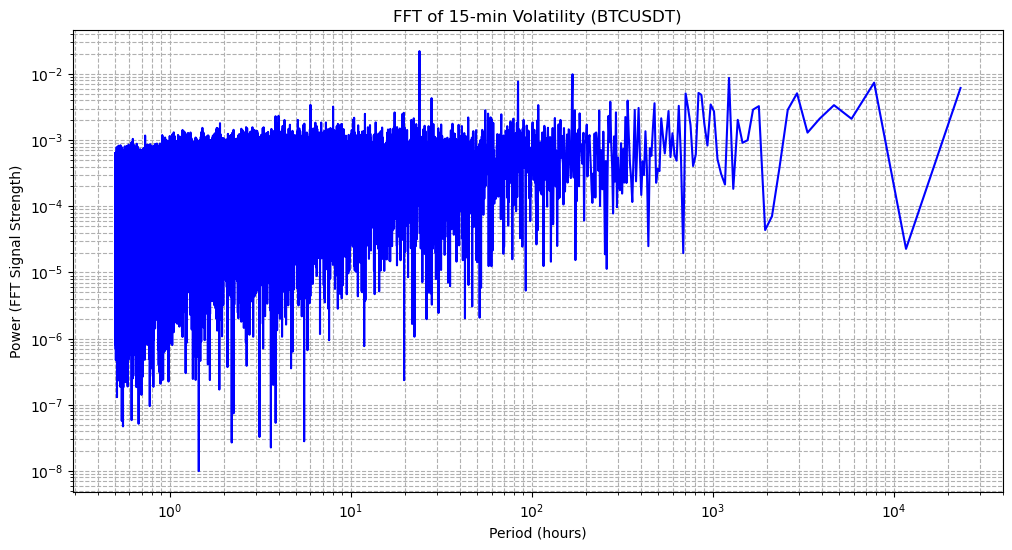

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設 df 有欄位 close_time (datetime) 與 close (價格)
df = pd.read_csv('BTCUSDT_15m_2023-01-01_to_2025-08-31.csv')
df["close_time"] = pd.to_datetime(df["close_time"])
df = df.set_index("close_time")

# Step 1: 計算報酬率 & 波動率
df["ret"] = np.log(df["close"] / df["close"].shift(1))
df["vol"] = df["ret"]**2
df = df.dropna()

# Step 2: FFT
vol = df["vol"].values
n = len(vol)
dt = 15/60  # 取樣間隔 = 0.25 小時 (15 分鐘)

fft_vals = np.fft.rfft(vol - np.mean(vol))
power = np.abs(fft_vals)**2
freqs = np.fft.rfftfreq(n, d=dt)
periods = 1 / freqs
periods[0] = np.nan  # 避免 inf

# Step 3: 建 DataFrame
df_fft = pd.DataFrame({
    "period": periods,
    "power": power
}).dropna()

# Step 4: 繪圖
plt.figure(figsize=(12,6))
plt.plot(df_fft["period"], df_fft["power"], color="blue")
plt.xscale("log")   # 週期取 log 軸會比較直觀
plt.yscale("log")
plt.xlabel("Period (hours)")
plt.ylabel("Power (FFT Signal Strength)")
plt.title("FFT of 15-min Volatility (BTCUSDT)")
plt.grid(True, which="both", ls="--")
plt.show()

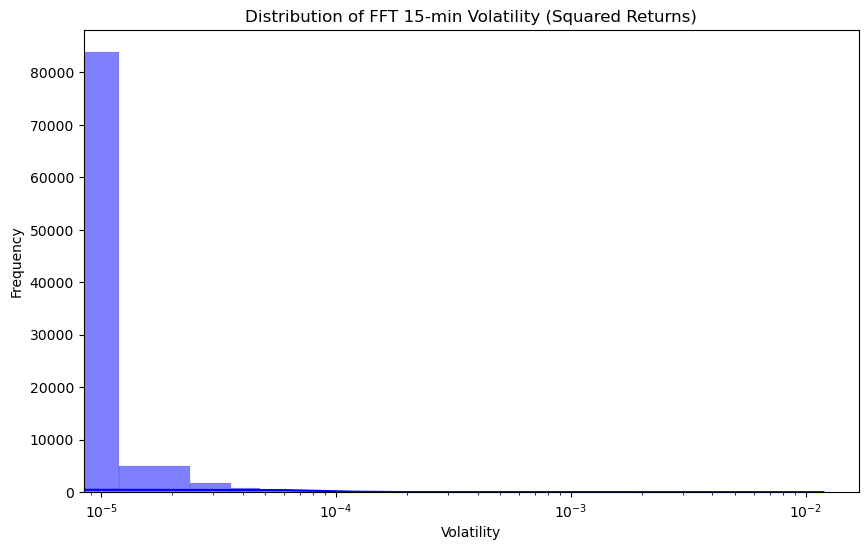

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df["vol"], bins=1000, kde=True, color="blue")
plt.title("Distribution of FFT 15-min Volatility (Squared Returns)")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.xscale("log")   # 建議加 log，看厚尾比較清楚
plt.show()

KeyError: nan

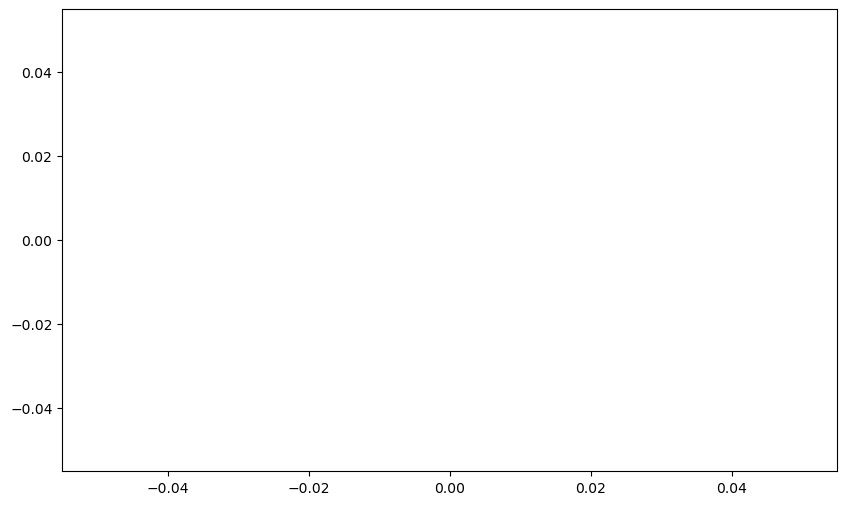

In [143]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 對數分箱
bins = np.logspace(np.log10(df["vol"].min()), np.log10(df["vol"].max()), 100)

plt.figure(figsize=(10,6))
sns.histplot(df["vol"], bins=bins, color="blue", alpha=0.6)
plt.xscale("log")
plt.title("Distribution of FFT 15-min Volatility (Log Bins)")
plt.xlabel("Volatility (log scale)")
plt.ylabel("Frequency")
plt.show()

In [145]:
df['vol']

close_time
2023-01-01 00:29:59.999    1.771674e-06
2023-01-01 00:44:59.999    2.288218e-06
2023-01-01 00:59:59.999    5.816801e-07
2023-01-01 01:14:59.999    3.881645e-07
2023-01-01 01:29:59.999    1.896378e-07
                               ...     
2025-08-31 22:59:59.999    1.755963e-07
2025-08-31 23:14:59.999    3.634379e-06
2025-08-31 23:29:59.999    7.560666e-06
2025-08-31 23:44:59.999    1.185628e-06
2025-08-31 23:59:59.999    9.414874e-09
Name: vol, Length: 93503, dtype: float64

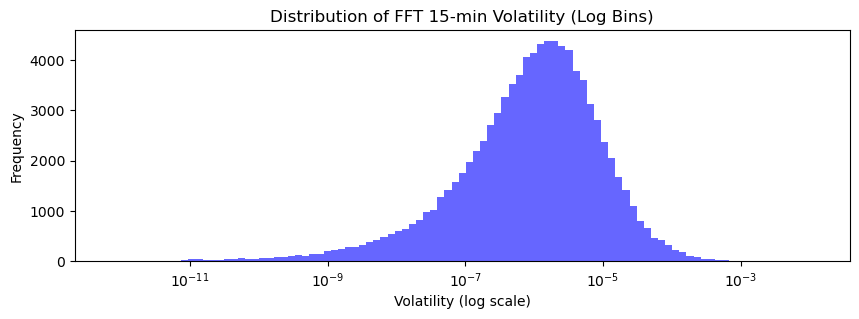

In [149]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 過濾掉 NaN 和非正數
clean_vol = df["vol"].dropna()
clean_vol = clean_vol[clean_vol > 0]

# 對數分箱
bins = np.logspace(np.log10(clean_vol.min()), np.log10(clean_vol.max()), 100)

plt.figure(figsize=(10,3))
sns.histplot(clean_vol, bins=bins, color="blue", alpha=0.6)
plt.xscale("log")
plt.title("Distribution of FFT 15-min Volatility (Log Bins)")
plt.xlabel("Volatility (log scale)")
plt.ylabel("Frequency")
plt.show()

### 驗證：頻率能量 vs. 波動 clustering：檢查尾部事件是否和 rolling FFT heatmap 中的「短期週期爆發」對應。

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

def rolling_fft_tail_analysis(series, window=300, step=15, dt=1, max_period=200, tail_q=0.95):
    """
    series: 一維波動率序列 (例如 df_1h["vol"])
    window: rolling FFT 視窗大小
    step: 每次移動步數
    dt: 取樣間隔 (1 = 1小時, 如果是15min就=0.25)
    max_period: 最大顯示週期
    tail_q: 尾部事件 quantile (例如 0.99 = 99% 分位數)
    """

    spectra = []
    times = []
    for start in range(0, len(series) - window, step):
        seg = series[start:start+window]
        fft_vals = np.fft.rfft(seg - np.mean(seg))
        power = np.abs(fft_vals)**2
        freqs = np.fft.rfftfreq(window, dt)
        periods = 1 / freqs
        valid = periods <= max_period
        spectra.append(power[valid])
        times.append(start)

    spectra = np.array(spectra).T
    periods = periods[valid]
    times = np.array(times)

    # ===== 找尾部事件 =====
    flat_power = spectra.flatten()
    threshold = np.quantile(flat_power, tail_q)

    tail_idx = np.where(spectra > threshold)
    tail_times = times[tail_idx[1]]
    tail_periods = periods[tail_idx[0]]

    # ===== 畫 Heatmap =====
    plt.figure(figsize=(12,6))
    plt.imshow(
        spectra, aspect='auto', origin='lower',
        extent=[times[0], times[-1], periods.min(), periods.max()],
        cmap="viridis", norm=colors.LogNorm()
    )
    plt.colorbar(label="Power (log scale)")
    plt.scatter(tail_times, tail_periods, color="red", s=8, label="Tail Events")

    plt.xlabel("Time Index")
    plt.ylabel("Period (hours)")
    plt.title(f"Rolling FFT Heatmap with Tail Events (>{int(tail_q*100)}% Power)")
    plt.legend()
    plt.show()

    # ===== 畫週期分布 (對比所有 vs 尾部事件) =====
    plt.figure(figsize=(10,6))
    sns.histplot(periods.repeat(spectra.shape[1]), bins=50, color="blue", alpha=0.4, stat="density", label="All Events")
    sns.histplot(tail_periods, bins=30, color="red", alpha=0.7, stat="density", label="Tail Events")
    plt.xlabel("Period (hours)")
    plt.ylabel("Density")
    plt.title("Period Distribution: All vs Tail Events")
    plt.legend()
    plt.show()

    return tail_times, tail_periods

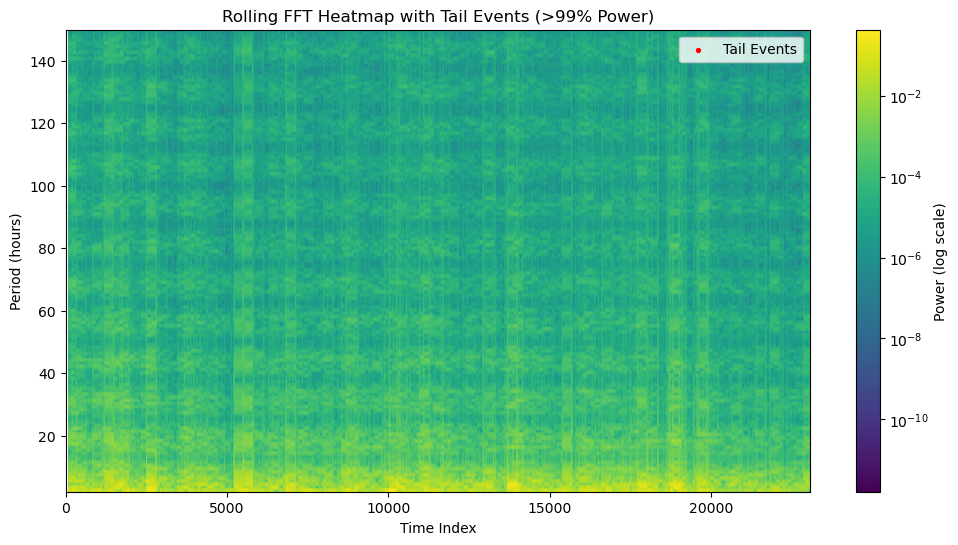

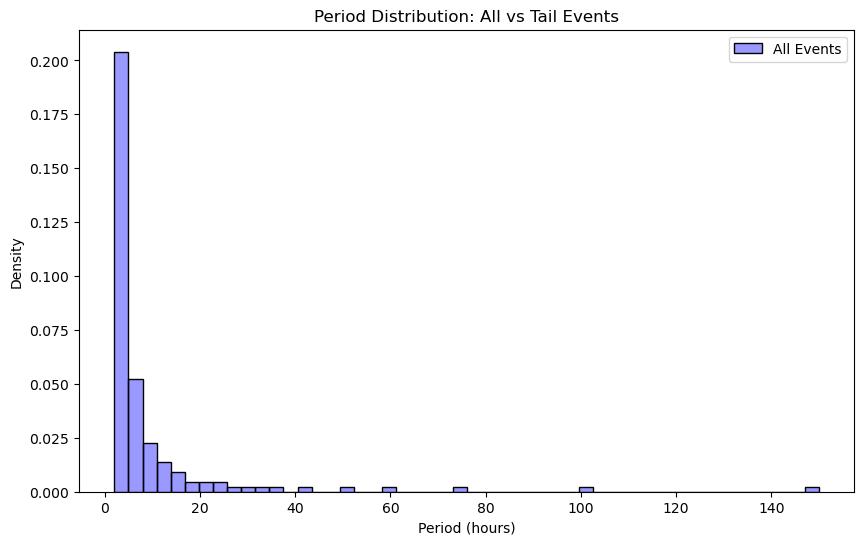

In [158]:
tail_times, tail_periods = rolling_fft_tail_analysis(df_1h["vol"], window=300, step=15, dt=1, max_period=200, tail_q=0.99)

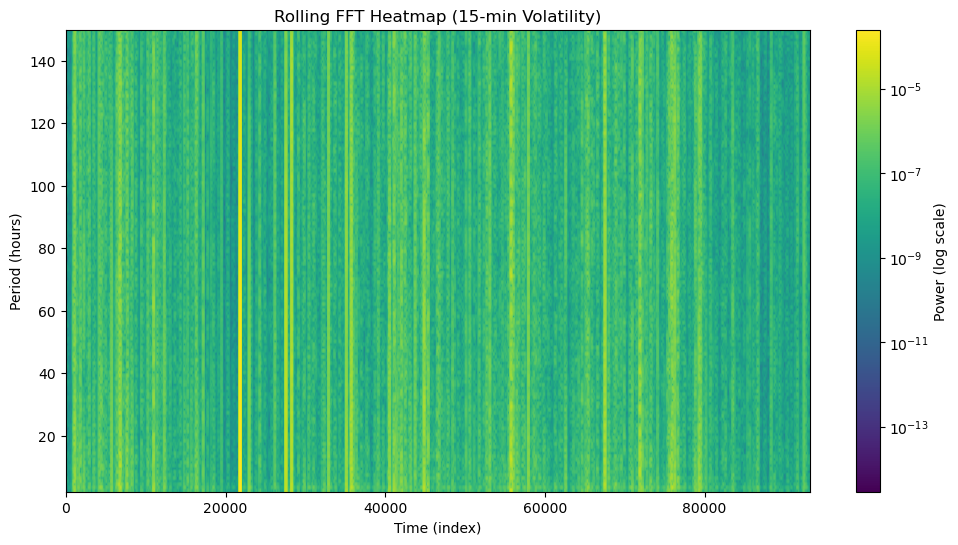

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def rolling_fft(vol_series, window=300, step=15, dt=1, max_period=200):
    spectra = []
    times = []
    
    for start in range(0, len(vol_series)-window, step):
        segment = vol_series[start:start+window]
        fft_vals = np.fft.rfft(segment - np.mean(segment))
        power = np.abs(fft_vals)**2
        freqs = np.fft.rfftfreq(window, d=dt)
        periods = 1/freqs[1:]   # 去掉 freq=0
        power = power[1:]
        
        mask = periods <= max_period
        spectra.append(power[mask])
        times.append(start)
    
    spectra = np.array(spectra).T  # shape: [n_periods, n_windows]
    periods = periods[mask]
    times = np.array(times)
    
    return spectra, periods, times

# 用法：
rolling_spectra, periods, times = rolling_fft(df["vol"].values, window=300, step=15, dt=1, max_period=200)

# 繪圖
plt.figure(figsize=(12,6))
plt.imshow(
    rolling_spectra, aspect='auto', origin='lower',
    extent=[times[0], times[-1], periods.min(), periods.max()],
    cmap="viridis", norm=colors.LogNorm()
)
plt.colorbar(label="Power (log scale)")
plt.xlabel("Time (index)")
plt.ylabel("Period (hours)")
plt.title("Rolling FFT Heatmap (15-min Volatility)")
plt.show()

In [162]:
import numpy as np

# 假設你之前有算 rolling_spectra (shape: [n_periods, n_windows])
# 如果還沒算，要先跑 rolling FFT 的函式拿到它
# 這裡示範 flatten
flat_power = rolling_spectra.flatten()

# 方法1：分位數
threshold_q95 = np.quantile(flat_power, 0.95)  # 取前 5%
threshold_q99 = np.quantile(flat_power, 0.99)  # 取前 1%

# 方法2：平均 + 標準差
threshold_std = np.mean(flat_power) + 2 * np.std(flat_power)

print("95% 分位數:", threshold_q95)
print("99% 分位數:", threshold_q99)
print("均值+2σ:", threshold_std)

# 接下來可以用這些 threshold 去篩選尾部事件
tail_idx = np.where(flat_power > threshold_q95)[0]

95% 分位數: 1.3759973799871334e-06
99% 分位數: 7.90414589382156e-06
均值+2σ: 1.902640190774602e-05


尾部事件數量: 9259 (threshold = 7.90e-06)


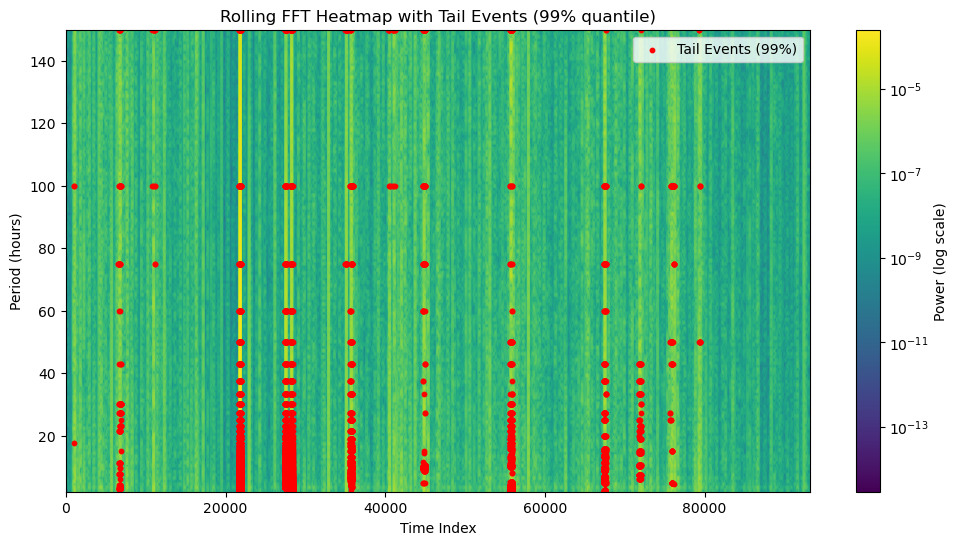

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# 假設你已經有 rolling_spectra, periods, times
# 計算 99% 分位數
flat_power = rolling_spectra.flatten()
threshold = np.quantile(flat_power, 0.99)

# 找出尾部事件
tail_idx = np.where(rolling_spectra > threshold)
tail_times = times[tail_idx[1]]
tail_periods = periods[tail_idx[0]]

print(f"尾部事件數量: {len(tail_times)} (threshold = {threshold:.2e})")

# 畫 Heatmap + 疊加尾部事件
plt.figure(figsize=(12,6))
plt.imshow(
    rolling_spectra, aspect='auto', origin='lower',
    extent=[times[0], times[-1], periods.min(), periods.max()],
    cmap="viridis", norm=colors.LogNorm()
)
plt.colorbar(label="Power (log scale)")
plt.scatter(tail_times, tail_periods, color="red", s=10, label="Tail Events (99%)")
plt.xlabel("Time Index")
plt.ylabel("Period (hours)")
plt.title("Rolling FFT Heatmap with Tail Events (99% quantile)")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


尾部事件比例 (各交易時段):
session
Asia      0.200490
Europe    0.199022
US        0.200162
Name: is_tail, dtype: float64


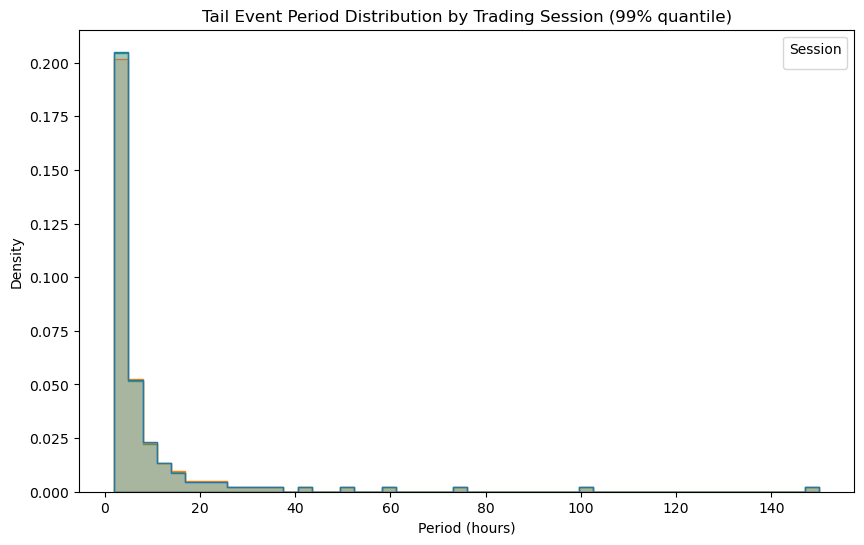

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

# === 假設已有 rolling_spectra, periods, times ===
# rolling_spectra shape: [n_periods, n_windows]
# times: 每個 window 的時間索引 (int or datetime)

# Step 1. 將資料攤平成 dataframe
n_periods, n_windows = rolling_spectra.shape
df_fft = pd.DataFrame({
    "period": np.tile(periods, n_windows),
    "power": rolling_spectra.flatten(),
    "time_index": np.repeat(times, n_periods)
})

# Step 2. 加入 hour/session 標籤 (假設 time_index 可轉成 datetime)
# 如果 time_index 只是整數，就要對應回原始 df_1h 的 timestamp
df_fft["datetime"] = pd.to_datetime(df_fft["time_index"], unit="h")  # 假設單位小時
df_fft["hour"] = df_fft["datetime"].dt.hour

def get_session(hour):
    if 8 <= hour < 17:   return "Asia"
    elif 16 <= hour < 24: return "Europe"
    else:               return "US"

df_fft["session"] = df_fft["hour"].apply(get_session)

# Step 3. 設定 tail event threshold
threshold = np.quantile(df_fft["power"], 0.80)  # 99% 分位數
df_fft["is_tail"] = df_fft["power"] > threshold

# Step 4. 統計各 session 的尾部事件比例
session_stats = df_fft.groupby("session")["is_tail"].mean()

print("尾部事件比例 (各交易時段):")
print(session_stats)

# Step 5. 畫圖：尾部事件分布 (直方圖)
plt.figure(figsize=(10,6))
sns.histplot(data=df_fft[df_fft["is_tail"]],
             x="period", hue="session",
             bins=50, stat="density", element="step", common_norm=False)
plt.title("Tail Event Period Distribution by Trading Session (99% quantile)")
plt.xlabel("Period (hours)")
plt.ylabel("Density")
plt.legend(title="Session")
plt.show()

In [172]:
def get_session(hour):
    if 0 <= hour < 8:   return "Asia"
    elif 8 <= hour < 16: return "Europe"
    else:               return "US"

# 如果 tail_events 裡有 datetime：
if "datetime" in tail_events.columns:
    tail_events["hour"] = tail_events["datetime"].dt.hour
    tail_events["session"] = tail_events["hour"].apply(get_session)
# 如果只有 hour：
elif "hour" in tail_events.columns:
    tail_events["session"] = tail_events["hour"].apply(get_session)

In [177]:
tail_events

period     power
1      23375.750000  0.006157
3       7791.916667  0.007415
4       5843.937500  0.002106
5       4675.150000  0.003386
6       3895.958333  0.002113
...             ...       ...
23331      1.001918  0.001156
24743      0.944742  0.001098
25631      0.912011  0.001178
25717      0.908961  0.001182
31902      0.732736  0.001175

[468 rows x 2 columns]

In [178]:
# 假設 df_fft 是完整的 FFT dataframe，包含 period, power, time_index, datetime
# tail_events = df_fft[df_fft["power"] > threshold]

# 如果你目前只有 rolling_spectra, periods, times，那就先建構 df_fft：
import pandas as pd
import numpy as np

n_periods, n_windows = rolling_spectra.shape
df_fft = pd.DataFrame({
    "period": np.tile(periods, n_windows),
    "power": rolling_spectra.flatten(),
    "time_index": np.repeat(times, n_periods)
})

# 補 datetime (假設你的 times 單位是小時，從起始時間算起)
df_fft["datetime"] = pd.to_datetime(df_fft["time_index"], unit="h")
df_fft["hour"] = df_fft["datetime"].dt.hour

# 建立 session
def get_session(hour):
    if 0 <= hour < 8:   return "Asia"
    elif 8 <= hour < 16: return "Europe"
    else:               return "US"

df_fft["session"] = df_fft["hour"].apply(get_session)

# 再抓 tail_events
threshold = np.quantile(df_fft["power"], 0.99)
tail_events = df_fft[df_fft["power"] > threshold]

print(tail_events.head())
print(tail_events.columns)

     period     power  time_index            datetime  hour session
446     2.0  0.000009          30 1970-01-02 06:00:00     6    Asia
447   150.0  0.000012          45 1970-01-02 21:00:00    21      US
448   100.0  0.000012          45 1970-01-02 21:00:00    21      US
449    75.0  0.000012          45 1970-01-02 21:00:00    21      US
450    60.0  0.000011          45 1970-01-02 21:00:00    21      US
Index(['period', 'power', 'time_index', 'datetime', 'hour', 'session'], dtype='object')


In [179]:
# 假設 tail_events 只有 period, power, time
# 先確認有沒有 datetime 或 hour
if "datetime" not in tail_events.columns:
    # 如果有 time (index 單位是小時數)
    tail_events["datetime"] = pd.to_datetime(tail_events["time"], unit="h")

# 建立 hour
tail_events["hour"] = tail_events["datetime"].dt.hour

# 建立 session 分組
def get_session(hour):
    if 0 <= hour < 8:   return "Asia"
    elif 8 <= hour < 16: return "Europe"
    else:               return "US"

tail_events["session"] = tail_events["hour"].apply(get_session)

print(tail_events.head())  # 檢查一下

     period     power  time_index            datetime  hour session
446     2.0  0.000009          30 1970-01-02 06:00:00     6    Asia
447   150.0  0.000012          45 1970-01-02 21:00:00    21      US
448   100.0  0.000012          45 1970-01-02 21:00:00    21      US
449    75.0  0.000012          45 1970-01-02 21:00:00    21      US
450    60.0  0.000011          45 1970-01-02 21:00:00    21      US


In [180]:
import scipy.stats as stats
import pandas as pd
import numpy as np

# --- KS Test ---
def ks_test_sessions(df, session1, session2):
    data1 = df[df["session"] == session1]["period"].values
    data2 = df[df["session"] == session2]["period"].values
    ks_stat, p_val = stats.ks_2samp(data1, data2)
    return ks_stat, p_val

# 跑亞洲 vs 歐美
for s in ["Europe", "US"]:
    ks_stat, p_val = ks_test_sessions(tail_events, "Asia", s)
    print(f"KS test Asia vs {s}: statistic={ks_stat:.4f}, p={p_val:.4e}")

# --- Chi-square test ---
# 分箱週期
bins = [0, 8, 12, 24, 48, np.inf]
labels = ["0-8h", "8-12h", "12-24h", "24-48h", ">48h"]
tail_events["period_bin"] = pd.cut(tail_events["period"], bins=bins, labels=labels)

# 各 session 的分布
contingency_table = pd.crosstab(tail_events["session"], tail_events["period_bin"])
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("\nChi-square Test Results:")
print("Chi2 stat =", chi2_stat)
print("p-value   =", p_val)
print("Degrees of freedom =", dof)
print("Expected freq table:\n", expected)

print("\nObserved contingency table:")
print(contingency_table)

KS test Asia vs Europe: statistic=0.0298, p=9.1203e-02
KS test Asia vs US: statistic=0.0353, p=5.8395e-02

Chi-square Test Results:
Chi2 stat = 8.865822664449677
p-value   = 0.3537412374133146
Degrees of freedom = 8
Expected freq table:
 [[2609.55200346  277.60406091  266.16027649  139.17118479  125.51247435]
 [2641.6178853   281.01522843  269.43082406  140.88130468  127.05475753]
 [1817.83011124  193.38071066  185.40889945   96.94751053   87.43276812]]

Observed contingency table:
period_bin  0-8h  8-12h  12-24h  24-48h  >48h
session                                      
Asia        2574    304     277     139   124
Europe      2635    275     276     142   132
US          1860    173     168      96    84


In [181]:
import scipy.stats as stats

# --- KS Test ---
def ks_test_sessions(df, session1, session2):
    data1 = df[df["session"] == session1]["period"].values
    data2 = df[df["session"] == session2]["period"].values
    ks_stat, p_val = stats.ks_2samp(data1, data2)
    return ks_stat, p_val

for s in ["Europe", "US"]:
    ks_stat, p_val = ks_test_sessions(tail_events, "Asia", s)
    print(f"KS test Asia vs {s}: statistic={ks_stat:.4f}, p={p_val:.4e}")

# --- Chi-square test ---
bins = [0, 8, 12, 24, 48, np.inf]
labels = ["0-8h", "8-12h", "12-24h", "24-48h", ">48h"]
tail_events["period_bin"] = pd.cut(tail_events["period"], bins=bins, labels=labels)

contingency_table = pd.crosstab(tail_events["session"], tail_events["period_bin"])
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("\nChi-square Test Results:")
print("Chi2 stat =", chi2_stat)
print("p-value   =", p_val)
print("Degrees of freedom =", dof)
print("\nObserved contingency table:")
print(contingency_table)

KS test Asia vs Europe: statistic=0.0298, p=9.1203e-02
KS test Asia vs US: statistic=0.0353, p=5.8395e-02

Chi-square Test Results:
Chi2 stat = 8.865822664449677
p-value   = 0.3537412374133146
Degrees of freedom = 8

Observed contingency table:
period_bin  0-8h  8-12h  12-24h  24-48h  >48h
session                                      
Asia        2574    304     277     139   124
Europe      2635    275     276     142   132
US          1860    173     168      96    84


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


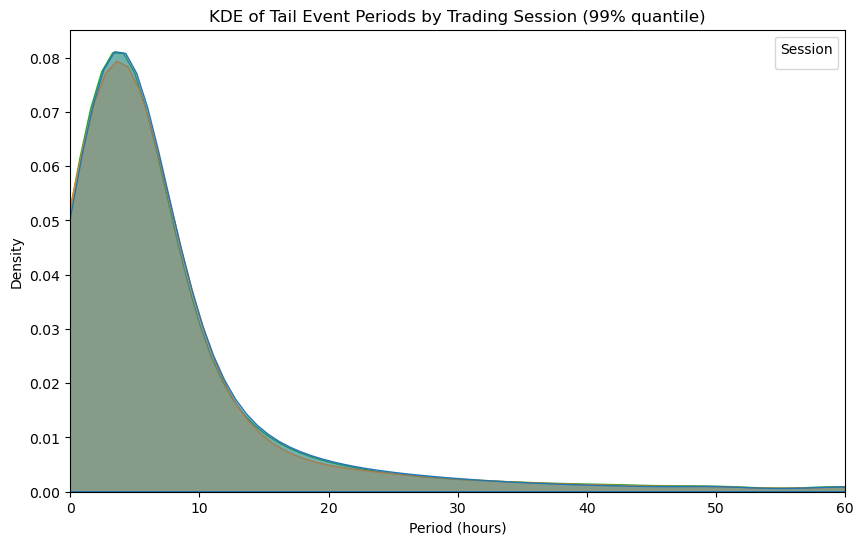

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.kdeplot(data=tail_events, x="period", hue="session", common_norm=False, fill=True, alpha=0.4)

plt.title("KDE of Tail Event Periods by Trading Session (99% quantile)")
plt.xlabel("Period (hours)")
plt.ylabel("Density")
plt.xlim(0, 60)  # 先聚焦 0-60h，方便觀察短週期差異
plt.legend(title="Session")
plt.show()

In [188]:
df_1h.columns

Index(['open', 'high', 'low', 'close', 'ret', 'vol', 'hour', 'session',
       'date'],
      dtype='object')

In [223]:
def get_precise_sessions(hour):
    if 0 <= hour < 2:
        return "Asia"
    elif 8 <= hour < 16:
        return "Europe"
    elif 13 <= hour < 21:
        return "US"
    else:
        return "Other"

# 用既有的 hour 欄位
df_1h["session"] = df_1h["hour"].apply(get_precise_sessions)

# 過濾掉非主要 session
df_session = df_1h[df_1h["session"] != "Other"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


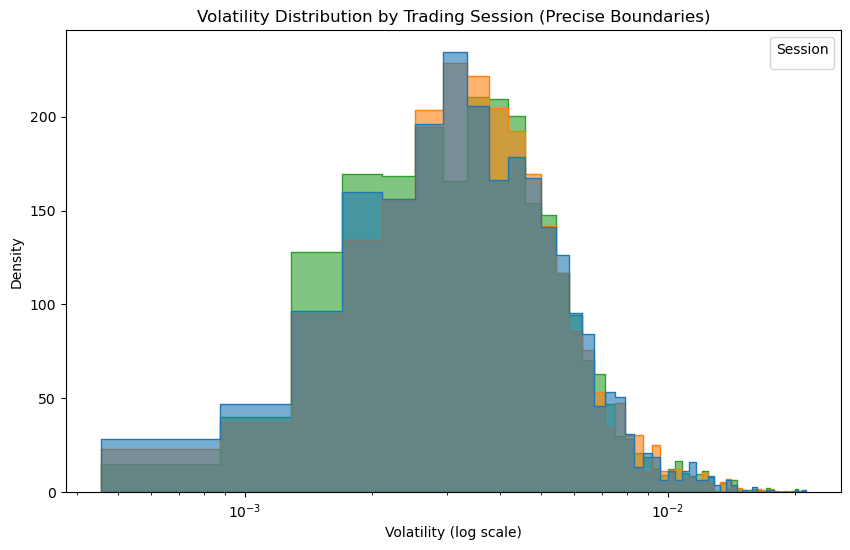

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(data=df_session, x="vol", hue="session",
             bins=50, stat="density", element="step", common_norm=False, alpha=0.6)
plt.xscale("log")
plt.title("Volatility Distribution by Trading Session (Precise Boundaries)")
plt.xlabel("Volatility (log scale)")
plt.ylabel("Density")
plt.legend(title="Session")
plt.show()

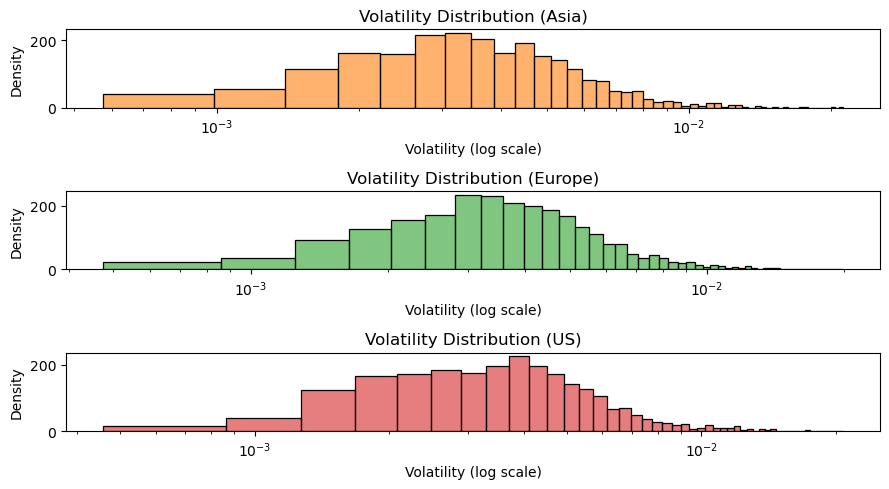

            mean       std  skewness  kurtosis
Asia    0.004427  0.002445  1.627058  4.638827
Europe  0.004450  0.002410  1.638507  4.346037
US      0.004422  0.002463  1.661843  4.504670


In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 分開畫直方圖
sessions = ["Asia", "Europe", "US"]
plt.figure(figsize=(9, 5))

for i, s in enumerate(sessions, 1):
    plt.subplot(3, 1, i)
    sns.histplot(df_session[df_session["session"] == s]["vol"],
                 bins=50, color="C"+str(i), stat="density", alpha=0.6)
    plt.xscale("log")
    plt.title(f"Volatility Distribution ({s})")
    plt.xlabel("Volatility (log scale)")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

# 計算統計量
stats_summary = {}
for s in sessions:
    data = df_session[df_session["session"] == s]["vol"].dropna()
    stats_summary[s] = {
        "mean": data.mean(),
        "std": data.std(),
        "skewness": skew(data),
        "kurtosis": kurtosis(data)
    }

import pandas as pd
summary_df = pd.DataFrame(stats_summary).T
print(summary_df)

In [226]:
df_1h

open      high       low     close       ret  \
close_time                                                              
2023-01-01 00:00:00   16537.5   16540.9   16504.0   16527.0       NaN   
2023-01-01 01:00:00   16527.1   16554.3   16524.1   16550.4  0.001416   
2023-01-01 02:00:00   16550.5   16557.1   16534.8   16542.4 -0.000483   
2023-01-01 03:00:00   16542.5   16542.5   16515.0   16529.3 -0.000792   
2023-01-01 04:00:00   16529.2   16530.4   16508.8   16517.8 -0.000696   
...                       ...       ...       ...       ...       ...   
2025-08-31 19:00:00  109089.0  109112.3  108857.1  108877.2 -0.001942   
2025-08-31 20:00:00  108877.3  109079.3  108821.8  109079.3  0.001856   
2025-08-31 21:00:00  109079.2  109079.2  108896.3  108986.4 -0.000852   
2025-08-31 22:00:00  108986.5  109192.3  108700.0  108842.4 -0.001321   
2025-08-31 23:00:00  108842.3  108866.7  108021.0  108208.4 -0.005825   

                          vol  hour session        date  
close_time                                               
2023-01-01 00:00:00       NaN     0    Asia  2023-01-01  
2023-01-01 01:00:00       NaN     1    Asia  2023-01-01  
2023-01-01 02:00:00       NaN     2   Other  2023-01-01  
2023-01-01 03:00:00       NaN     3   Other  2023-01-01  
2023-01-01 04:00:00       NaN     4   Other  2023-01-01  
...                       ...   ...     ...         ...  
2025-08-31 19:00:00  0.002146    19      US  2025-08-31  
2025-08-31 20:00:00  0.002147    20      US  2025-08-31  
2025-08-31 21:00:00  0.002151    21   Other  2025-08-31  
2025-08-31 22:00:00  0.002169    22   Other  2025-08-31  
2025-08-31 23:00:00  0.002420    23   Other  2025-08-31  

[23376 rows x 9 columns]

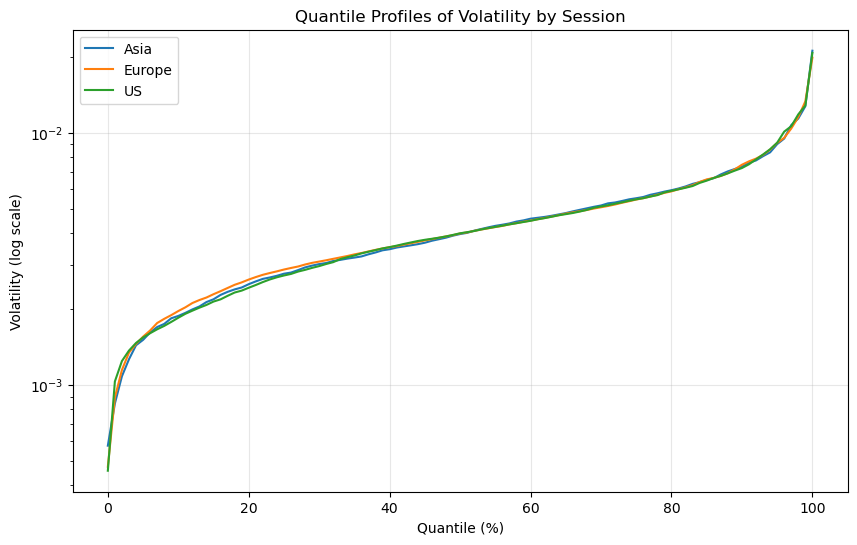

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sessions = ["Asia", "Europe", "US"]
quantiles = np.linspace(0, 1, 101)  # 0% ~ 100%

plt.figure(figsize=(10,6))

for s in sessions:
    data = df_1h[df_1h["session"] == s]["vol"].dropna().values
    q_vals = np.quantile(data, quantiles)
    plt.plot(quantiles*100, q_vals, label=s)

plt.yscale("log")  # 因為尾部跨度大，用對數軸比較直觀
plt.xlabel("Quantile (%)")
plt.ylabel("Volatility (log scale)")
plt.title("Quantile Profiles of Volatility by Session")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

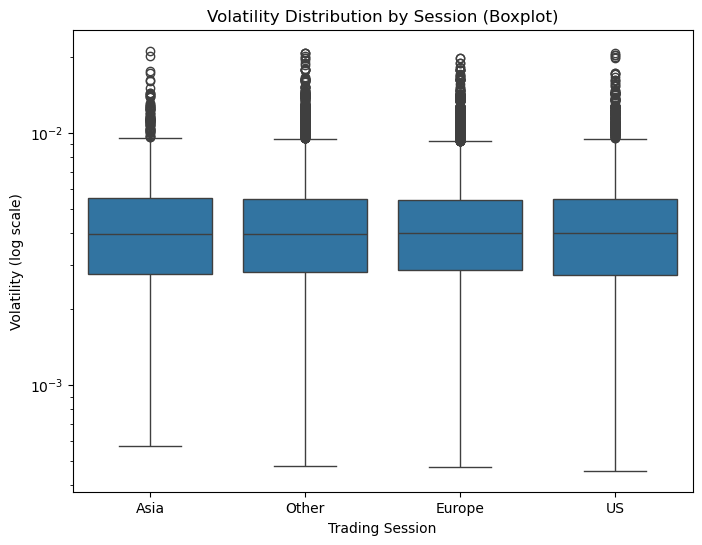

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(data=df_1h, x="session", y="vol", showfliers=True)  # showfliers=True 顯示尾部異常值
plt.yscale("log")  # 因為波動率分布長尾，用對數軸更清楚
plt.title("Volatility Distribution by Session (Boxplot)")
plt.xlabel("Trading Session")
plt.ylabel("Volatility (log scale)")
plt.show()

In [229]:
import scipy.stats as stats
import pandas as pd

# 假設 df_1h 已經有 'vol' (波動率) 與 'session' (Asia/Europe/US)
results = {}

# 1. Welch's t-test (比較均值)
for s in ["Europe", "US"]:
    asia_vol = df_1h[df_1h["session"]=="Asia"]["vol"].dropna()
    other_vol = df_1h[df_1h["session"]==s]["vol"].dropna()
    t_stat, p_val = stats.ttest_ind(asia_vol, other_vol, equal_var=False)
    results[f"t-test Asia vs {s}"] = {"t-stat": t_stat, "p-val": p_val}

# 2. Levene’s test (比較方差)
for s in ["Europe", "US"]:
    asia_vol = df_1h[df_1h["session"]=="Asia"]["vol"].dropna()
    other_vol = df_1h[df_1h["session"]==s]["vol"].dropna()
    lev_stat, p_val = stats.levene(asia_vol, other_vol, center="median")
    results[f"Levene test Asia vs {s}"] = {"Levene-stat": lev_stat, "p-val": p_val}

# 3. 分位數比較
quantiles = [0.5, 0.75, 0.9, 0.95]
q_summary = df_1h.groupby("session")["vol"].quantile(quantiles).unstack()

# 輸出
print("=== 統計檢定結果 ===")
for test, vals in results.items():
    print(f"{test}: {vals}")

print("\n=== 分位數對比 (Volatility) ===")
print(q_summary)

=== 統計檢定結果 ===
t-test Asia vs Europe: {'t-stat': -0.3799669590316846, 'p-val': 0.7039971946176229}
t-test Asia vs US: {'t-stat': 0.0779302249273076, 'p-val': 0.9378878788165967}
Levene test Asia vs Europe: {'Levene-stat': 1.520396201467722, 'p-val': 0.2175893408961647}
Levene test Asia vs US: {'Levene-stat': 0.06969361030814916, 'p-val': 0.7917913956104788}

=== 分位數對比 (Volatility) ===
             0.50      0.75      0.90      0.95
session                                        
Asia     0.003970  0.005507  0.007348  0.009022
Europe   0.003992  0.005441  0.007476  0.009124
Other    0.003966  0.005475  0.007441  0.008956
US       0.003998  0.005452  0.007254  0.009143


### 亞洲開盤前、後五小時波動率變動

=== Summary ===
                     mean       std    median  skew  kurtosis
refined_session                                              
Asia-Post        0.004449  0.002410  0.003984   NaN       NaN
Asia-Pre         0.004446  0.002411  0.003965   NaN       NaN
Europe           0.004422  0.002463  0.003998   NaN       NaN
US               0.004423  0.002457  0.003964   NaN       NaN

=== Quantiles ===
                     0.50      0.75      0.90      0.95
refined_session                                        
Asia-Post        0.003984  0.005434  0.007521  0.009089
Asia-Pre         0.003965  0.005438  0.007530  0.008937
Europe           0.003998  0.005452  0.007254  0.009143
US               0.003964  0.005519  0.007375  0.009023


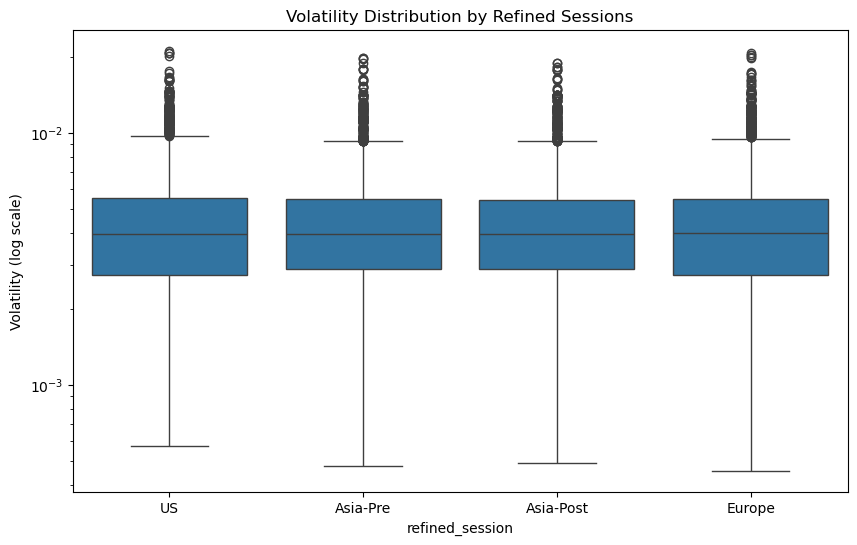


T-test Asia-Pre vs Asia-Post: t=nan, p=nan
=== Summary ===
                     mean       std    median  skew  kurtosis
refined_session                                              
Asia-Post        0.004449  0.002410  0.003984   NaN       NaN
Asia-Pre         0.004446  0.002411  0.003965   NaN       NaN
Europe           0.004422  0.002463  0.003998   NaN       NaN
US               0.004423  0.002457  0.003964   NaN       NaN

=== Quantiles ===
                     0.50      0.75      0.90      0.95
refined_session                                        
Asia-Post        0.003984  0.005434  0.007521  0.009089
Asia-Pre         0.003965  0.005438  0.007530  0.008937
Europe           0.003998  0.005452  0.007254  0.009143
US               0.003964  0.005519  0.007375  0.009023


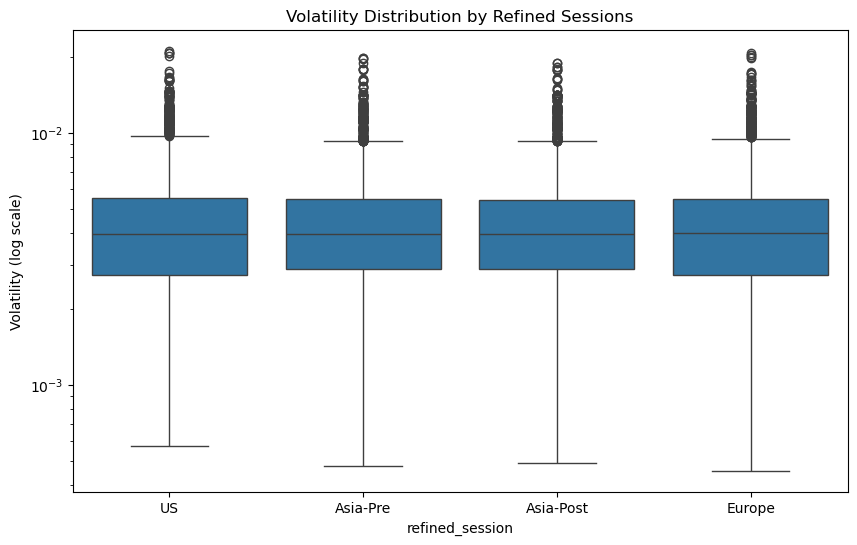


T-test Asia-Pre vs Asia-Post: t=nan, p=nan


In [247]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# 建立新的分類欄位
def refine_asia_sessions(hour):
    if 3 <= hour < 7:
        return "Asia-Pre"
    elif 8 <= hour < 12:
        return "Asia-Post"
    elif 16 <= hour < 21:
        return "Europe"
    elif (21 <= hour <= 23) or (0 <= hour < 2):
        return "US"
    else:
        return "Other"

df_1h["refined_session"] = df_1h["hour"].apply(refine_asia_sessions)

# 只取主要 session
main_sessions = df_1h[df_1h["refined_session"].isin(["Asia-Pre","Asia-Post","Europe","US"])]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# --- 計算 skewness & kurtosis 的函式 ---
def skewness(x):
    return stats.skew(x, bias=False)

def kurt(x):
    return stats.kurtosis(x, fisher=True, bias=False)  # Fisher=True => excess kurtosis

# --- 描述統計 ---
stats_summary = main_sessions.groupby("refined_session")["vol"].agg(
    mean="mean",
    std="std",
    median="median",
    skew=skewness,
    kurtosis=kurt
)

# --- 分位數 ---
quantiles = main_sessions.groupby("refined_session")["vol"].quantile([0.5,0.75,0.9,0.95]).unstack()

print("=== Summary ===")
print(stats_summary)
print("\n=== Quantiles ===")
print(quantiles)

# --- 視覺化 ---
plt.figure(figsize=(10,6))
sns.boxplot(data=main_sessions, x="refined_session", y="vol")
plt.yscale("log")
plt.title("Volatility Distribution by Refined Sessions")
plt.ylabel("Volatility (log scale)")
plt.show()

# --- t-test Asia-Pre vs Asia-Post ---
pre = main_sessions[main_sessions["refined_session"]=="Asia-Pre"]["vol"]
post = main_sessions[main_sessions["refined_session"]=="Asia-Post"]["vol"]
t_stat, p_val = stats.ttest_ind(pre, post, equal_var=False)
print(f"\nT-test Asia-Pre vs Asia-Post: t={t_stat:.4f}, p={p_val:.4e}")

# 分位數
quantiles = main_sessions.groupby("refined_session")["vol"].quantile([0.5,0.75,0.9,0.95]).unstack()

print("=== Summary ===")
print(stats_summary)
print("\n=== Quantiles ===")
print(quantiles)

# --- 視覺化 ---
plt.figure(figsize=(10,6))
sns.boxplot(data=main_sessions, x="refined_session", y="vol")
plt.yscale("log")
plt.title("Volatility Distribution by Refined Sessions")
plt.ylabel("Volatility (log scale)")
plt.show()

# --- t-test Asia-Pre vs Asia-Post ---
pre = main_sessions[main_sessions["refined_session"]=="Asia-Pre"]["vol"]
post = main_sessions[main_sessions["refined_session"]=="Asia-Post"]["vol"]
t_stat, p_val = stats.ttest_ind(pre, post, equal_var=False)
print(f"\nT-test Asia-Pre vs Asia-Post: t={t_stat:.4f}, p={p_val:.4e}")

In [253]:
from statsmodels.tsa.stattools import acf

# (A) Return ACF by session
acf_results = {}
for s in ["Asia-Pre","Asia-Post","Europe","US"]:
    data = df_1h[df_1h["refined_session"]==s]["ret"].dropna()
    acf_vals = acf(data, nlags=10, fft=True)
    acf_results[s] = acf_vals

print("=== Return ACF (前 10 lag) ===")
for s, vals in acf_results.items():
    print(f"{s}: {vals[:5]}")  # 只列前5個 lag

# (B) Volatility clustering
acf_vol = {}
for s in ["Asia-Pre","Asia-Post","Europe","US"]:
    data = df_1h[df_1h["refined_session"]==s]["ret"].dropna()**2
    acf_vals = acf(data, nlags=10, fft=True)
    acf_vol[s] = acf_vals

print("\n=== Squared Return ACF (波動聚集檢定) ===")
for s, vals in acf_vol.items():
    print(f"{s}: {vals[:5]}")

# (C) 簡易 scalping 策略模擬
def simple_scalping_strategy(data, threshold=0.002):
    pnl = []
    for i in range(1, len(data)):
        r = data.iloc[i]
        prev = data.iloc[i-1]
        # mean-reversion rule
        if prev > threshold:   # 過度上漲 → short
            pnl.append(-r)
        elif prev < -threshold: # 過度下跌 → long
            pnl.append(r)
    return np.mean(pnl), np.std(pnl)

strategy_results = {}
for s in ["Asia-Pre","Asia-Post","Europe","US"]:
    data = df_1h[df_1h["refined_session"]==s]["ret"].dropna()
    mean_pnl, std_pnl = simple_scalping_strategy(data)
    strategy_results[s] = {"mean_pnl": mean_pnl, "std_pnl": std_pnl}

print("\n=== 簡易 Scalping 策略結果 ===")
print(pd.DataFrame(strategy_results).T)

=== Return ACF (前 10 lag) ===
Asia-Pre: [ 1.00000000e+00 -2.41775303e-02  2.15521325e-04 -1.69329510e-03
  2.31336615e-02]
Asia-Post: [ 1.         -0.03630063 -0.00344249 -0.02658099  0.00830919]
Europe: [ 1.          0.00221161  0.01658724  0.01456223 -0.04116606]
US: [ 1.         -0.04331131  0.00517663 -0.00612027 -0.01988015]

=== Squared Return ACF (波動聚集檢定) ===
Asia-Pre: [1.         0.06643878 0.04074565 0.03313091 0.02051726]
Asia-Post: [1.         0.08261775 0.08128368 0.05700551 0.02395936]
Europe: [1.         0.17324737 0.04092554 0.04134687 0.05883709]
US: [1.         0.1409935  0.03797073 0.04865076 0.04275995]

=== 簡易 Scalping 策略結果 ===
           mean_pnl   std_pnl
Asia-Pre   0.000124  0.004220
Asia-Post  0.000055  0.004349
Europe    -0.000077  0.006405
US         0.000055  0.006103


In [254]:
pd.DataFrame(strategy_results).T

mean_pnl   std_pnl
Asia-Pre   0.000124  0.004220
Asia-Post  0.000055  0.004349
Europe    -0.000077  0.006405
US         0.000055  0.006103

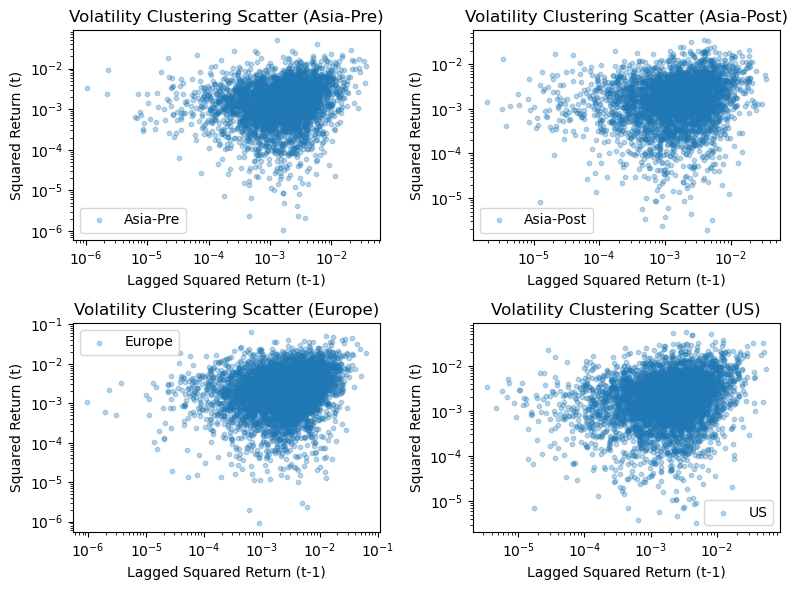

In [263]:
import matplotlib.pyplot as plt

# 使用 squared return 當作波動率 proxy
df_1h["squared_ret"] = df_1h["ret"].abs()

# 建立 X=lag, Y=current
df_1h["squared_ret_lag1"] = df_1h["squared_ret"].shift(1)

# 選擇特定 session，例如 Asia-Pre, Asia-Post, Europe, US
sessions = ["Asia-Pre", "Asia-Post", "Europe", "US"]

plt.figure(figsize=(8, 6))
for i, s in enumerate(sessions, 1):
    plt.subplot(2, 2, i)
    subset = df_1h[df_1h["refined_session"]==s].dropna()
    plt.scatter(subset["squared_ret_lag1"], subset["squared_ret"], 
                alpha=0.3, s=10, label=s)
    plt.xlabel("Lagged Squared Return (t-1)")
    plt.ylabel("Squared Return (t)")
    plt.title(f"Volatility Clustering Scatter ({s})")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()

plt.tight_layout()
plt.show()

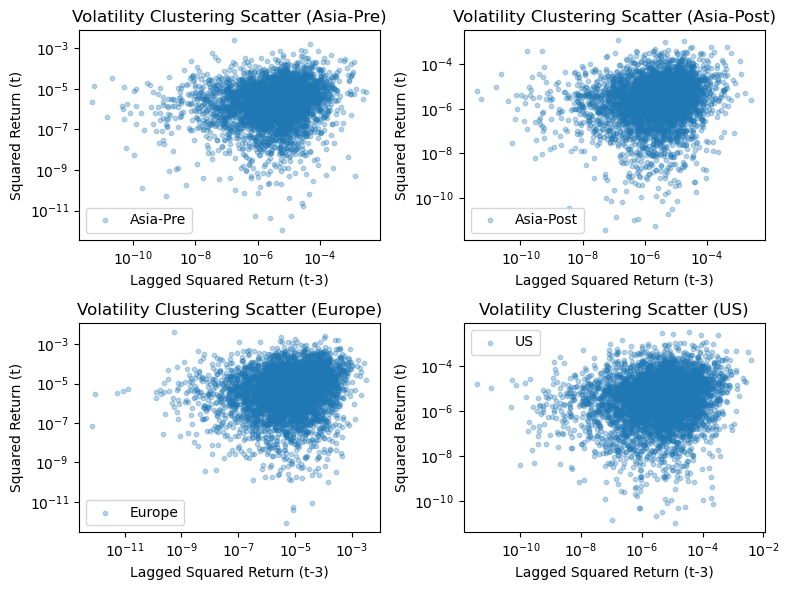

In [261]:
# 建立 X=lag, Y=current
df_1h["squared_ret_lag1"] = df_1h["squared_ret"].shift(3)

# 選擇特定 session，例如 Asia-Pre, Asia-Post, Europe, US
sessions = ["Asia-Pre", "Asia-Post", "Europe", "US"]

plt.figure(figsize=(8, 6))
for i, s in enumerate(sessions, 1):
    plt.subplot(2, 2, i)
    subset = df_1h[df_1h["refined_session"]==s].dropna()
    plt.scatter(subset["squared_ret_lag1"], subset["squared_ret"], 
                alpha=0.3, s=10, label=s)
    plt.xlabel("Lagged Squared Return (t-3)")
    plt.ylabel("Squared Return (t)")
    plt.title(f"Volatility Clustering Scatter ({s})")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()

plt.tight_layout()
plt.show()

=== Volatility Clustering Correlations ===
     Session  Corr_lag1  Corr_lag3
0   Asia-Pre   0.138705   0.050683
1      Other   0.167470   0.074935
2  Asia-Post   0.091657   0.062862
3     Europe   0.210315   0.054138
4         US   0.145958   0.064403


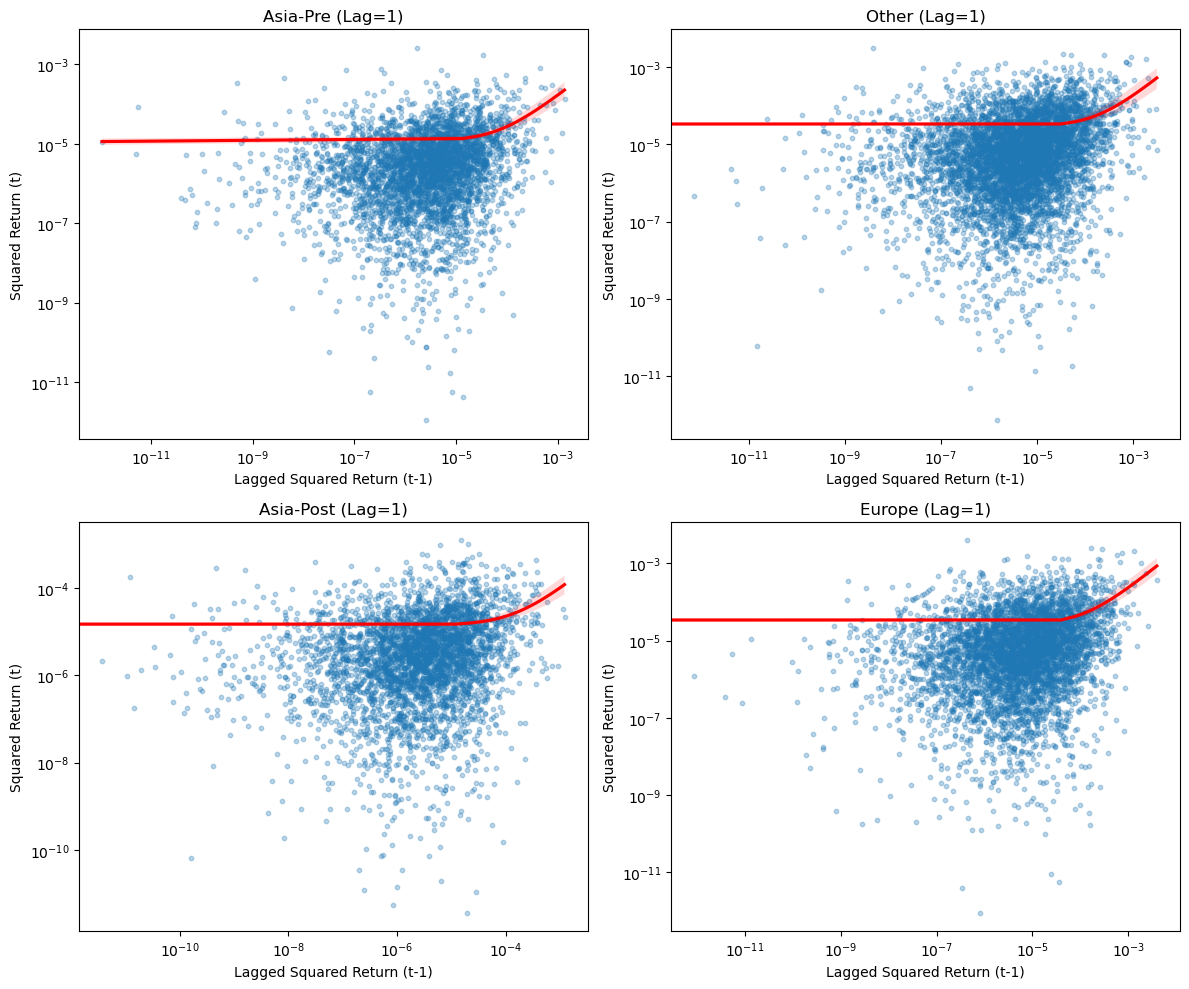

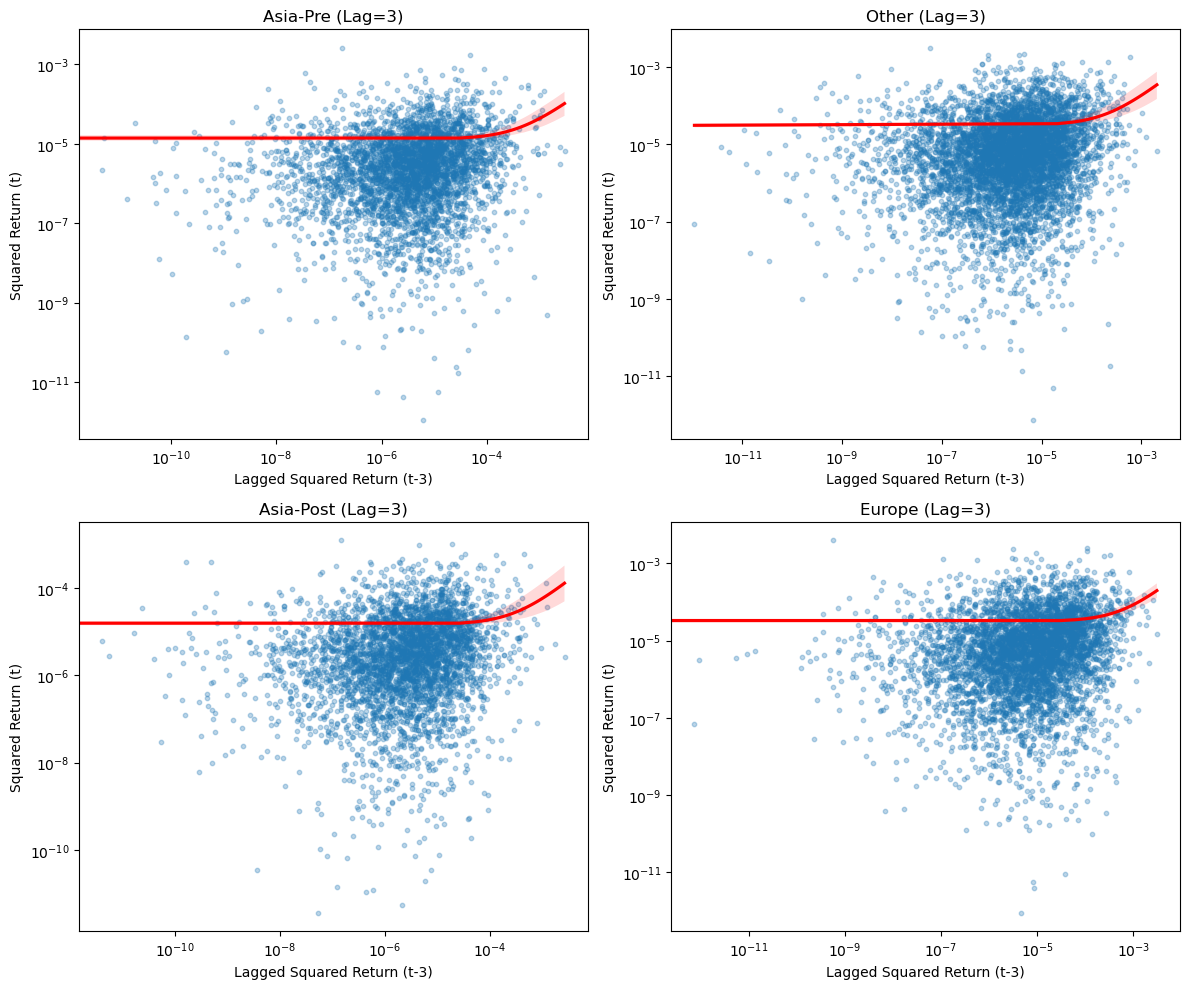

In [264]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- 準備資料 ---
df_corr = df_1h.copy()
df_corr["vol2"] = df_corr["ret"]**2  # 或直接用 vol，如果你定義的是 squared return

# Lag 計算
df_corr["vol2_lag1"] = df_corr["vol2"].shift(1)
df_corr["vol2_lag3"] = df_corr["vol2"].shift(3)

# 移除 NA
df_corr = df_corr.dropna(subset=["vol2","vol2_lag1","vol2_lag3"])

# --- 計算相關係數 ---
results = []
for session in df_corr["refined_session"].unique():
    data = df_corr[df_corr["refined_session"] == session]
    corr_lag1, _ = pearsonr(data["vol2"], data["vol2_lag1"])
    corr_lag3, _ = pearsonr(data["vol2"], data["vol2_lag3"])
    results.append([session, corr_lag1, corr_lag3])

corr_df = pd.DataFrame(results, columns=["Session","Corr_lag1","Corr_lag3"])
print("=== Volatility Clustering Correlations ===")
print(corr_df)

# --- 繪製回歸線 (Lag=1 vs Lag=3) ---
fig, axes = plt.subplots(2, 2, figsize=(12,10))
sessions = df_corr["refined_session"].unique()

for ax, session in zip(axes.flatten(), sessions):
    data = df_corr[df_corr["refined_session"] == session]
    sns.regplot(
        x="vol2_lag1", y="vol2",
        data=data, scatter_kws={'alpha':0.3, 's':10},
        line_kws={'color':'red'}, ax=ax
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"{session} (Lag=1)")
    ax.set_xlabel("Lagged Squared Return (t-1)")
    ax.set_ylabel("Squared Return (t)")

plt.tight_layout()
plt.show()

# 再畫 Lag=3
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, session in zip(axes.flatten(), sessions):
    data = df_corr[df_corr["refined_session"] == session]
    sns.regplot(
        x="vol2_lag3", y="vol2",
        data=data, scatter_kws={'alpha':0.3, 's':10},
        line_kws={'color':'red'}, ax=ax
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"{session} (Lag=3)")
    ax.set_xlabel("Lagged Squared Return (t-3)")
    ax.set_ylabel("Squared Return (t)")

plt.tight_layout()
plt.show()

### 15min Volatility Clustering

In [266]:
df["ret"] = df["close"].pct_change()
df["sq_ret"] = df["ret"]**2

In [267]:
df

open_time      open      high       low  \
close_time                                                                   
2023-01-01 00:29:59.999  2023-01-01 00:15:00   16517.4   16540.9   16513.4   
2023-01-01 00:44:59.999  2023-01-01 00:30:00   16539.3   16539.4   16504.0   
2023-01-01 00:59:59.999  2023-01-01 00:45:00   16514.5   16533.1   16513.9   
2023-01-01 01:14:59.999  2023-01-01 01:00:00   16527.1   16539.0   16524.1   
2023-01-01 01:29:59.999  2023-01-01 01:15:00   16537.2   16537.3   16528.6   
...                                      ...       ...       ...       ...   
2025-08-31 22:59:59.999  2025-08-31 22:45:00  108796.7  108887.5  108700.0   
2025-08-31 23:14:59.999  2025-08-31 23:00:00  108842.3  108866.7  108557.6   
2025-08-31 23:29:59.999  2025-08-31 23:15:00  108635.1  108635.1  108300.0   
2025-08-31 23:44:59.999  2025-08-31 23:30:00  108336.7  108388.4  108021.0   
2025-08-31 23:59:59.999  2025-08-31 23:45:00  108218.9  108314.1  108116.6   

                            close    volume  quote_asset_volume  \
close_time                                                        
2023-01-01 00:29:59.999   16539.4  1312.854        2.169977e+07   
2023-01-01 00:44:59.999   16514.4  1806.819        2.984469e+07   
2023-01-01 00:59:59.999   16527.0   741.846        1.225921e+07   
2023-01-01 01:14:59.999   16537.3   935.879        1.547247e+07   
2023-01-01 01:29:59.999   16530.1   521.977        8.629403e+06   
...                           ...       ...                 ...   
2025-08-31 22:59:59.999  108842.4   600.194        6.529195e+07   
2025-08-31 23:14:59.999  108635.1   985.709        1.070972e+08   
2025-08-31 23:29:59.999  108336.8  1998.590        2.167275e+08   
2025-08-31 23:44:59.999  108218.9  3245.866        3.511658e+08   
2025-08-31 23:59:59.999  108208.4  1365.040        1.477152e+08   

                         number_of_trades  taker_buy_base_asset_volume  \
close_time                                                               
2023-01-01 00:29:59.999              7474                      765.737   
2023-01-01 00:44:59.999              9773                      753.099   
2023-01-01 00:59:59.999              5195                      415.472   
2023-01-01 01:14:59.999              5576                      600.744   
2023-01-01 01:29:59.999              3405                      196.180   
...                                   ...                          ...   
2025-08-31 22:59:59.999             15186                      259.060   
2025-08-31 23:14:59.999             23199                      355.478   
2025-08-31 23:29:59.999             37012                      736.187   
2025-08-31 23:44:59.999             52789                     1798.065   
2025-08-31 23:59:59.999             27211                      734.671   

                         taker_buy_quote_asset_volume  ignore       ret  \
close_time                                                                
2023-01-01 00:29:59.999                  1.265735e+07       0       NaN   
2023-01-01 00:44:59.999                  1.243763e+07       0 -0.001512   
2023-01-01 00:59:59.999                  6.865808e+06       0  0.000763   
2023-01-01 01:14:59.999                  9.931656e+06       0  0.000623   
2023-01-01 01:29:59.999                  3.243327e+06       0 -0.000435   
...                                               ...     ...       ...   
2025-08-31 22:59:59.999                  2.818375e+07       0  0.000419   
2025-08-31 23:14:59.999                  3.862418e+07       0 -0.001905   
2025-08-31 23:29:59.999                  7.983358e+07       0 -0.002746   
2025-08-31 23:44:59.999                  1.945648e+08       0 -0.001088   
2025-08-31 23:59:59.999                  7.950233e+07       0 -0.000097   

                                  vol        sq_ret  
close_time                                           
2023-01-01 00:29:59.999  1.771674e-06           NaN  
2023-01-01 00:44:59.999  2.288218e-06  2.284760

In [270]:
df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore', 'ret', 'vol', 'sq_ret'],
      dtype='object')

In [275]:
# 把 open_time 轉成 datetime (Binance 匯出的通常是毫秒 timestamp)
df["datetime"] = pd.to_datetime(df["open_time"])
df["hour"] = df["datetime"].dt.hour

# 定義交易時段分割
def get_session(hour):
    if 0 <= hour < 8:   # 0:00–7:59
        return "Asia"
    elif 8 <= hour < 16: # 8:00–15:59
        return "Europe"
    else:               # 16:00–23:59
        return "US"

df["session"] = df["hour"].apply(get_session)

# 再跑 squared return 的自相關
results = []
for s in df["session"].unique():
    sub = df[df["session"]==s].dropna()
    lag1 = sub["sq_ret"].autocorr(lag=1)
    lag3 = sub["sq_ret"].autocorr(lag=3)
    results.append({"Session": s, "Corr_lag1": lag1, "Corr_lag3": lag3})

results_df = pd.DataFrame(results)
print("=== Volatility Clustering Correlations (15m) ===")
print(results_df)

=== Volatility Clustering Correlations (15m) ===
  Session  Corr_lag1  Corr_lag3
0    Asia   0.195434   0.119108
1  Europe   0.299305   0.093123
2      US   0.273127   0.026893


In [276]:
results_df

Session  Corr_lag1  Corr_lag3
0    Asia   0.195434   0.119108
1  Europe   0.299305   0.093123
2      US   0.273127   0.026893

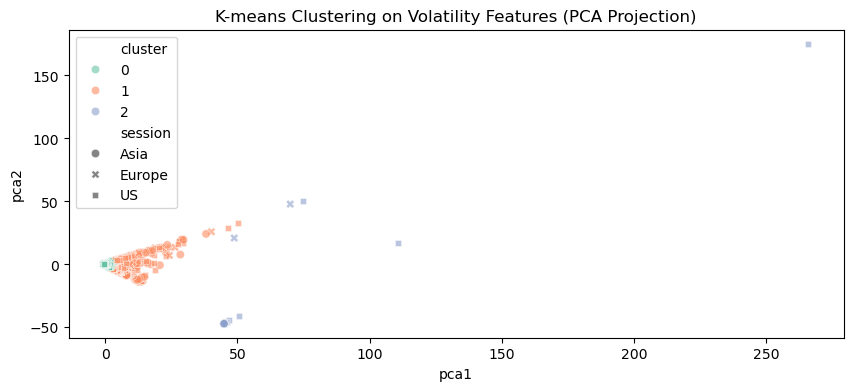

Cluster 分布 (各時段):
cluster      0    1   2
session                
Asia     30550  580  14
Europe   30852  314   2
US       30362  795  11


In [286]:
import pandas as pd
import numpy as np
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: 特徵工程 ---
df_ml = df.copy()

# 滾動特徵
df_ml["vol_mean24"] = df_ml["vol"].rolling(24).mean()
df_ml["vol_std24"] = df_ml["vol"].rolling(24).std()

# 填補 NaN
df_ml = df_ml.dropna()

# 選擇特徵
features = ["vol", "sq_ret", "vol_mean24", "vol_std24"]
X = df_ml[features].values

# --- Step 2: 標準化 ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 3: K-means ---
centroids, labels = kmeans2(X_scaled, 3, minit="++")
df_ml["cluster"] = labels
# --- Step 4: PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_ml["pca1"] = pca_result[:,0]
df_ml["pca2"] = pca_result[:,1]

# --- Step 5: 視覺化 ---
plt.figure(figsize=(10,4))
sns.scatterplot(
    data=df_ml, x="pca1", y="pca2",
    hue="cluster", style="session", palette="Set2", alpha=0.6
)
plt.title("K-means Clustering on Volatility Features (PCA Projection)")
plt.show()

# --- Step 6: 統計分布 ---
cluster_dist = df_ml.groupby(["session","cluster"]).size().unstack().fillna(0)
print("Cluster 分布 (各時段):")
print(cluster_dist)